## Environment Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# hack - https://github.com/googlecolab/colabtools/issues/3409#issuecomment-1446281277
import locale
locale.getpreferredencoding = lambda: "UTF-8"
! pip install -Uq ipdb
import ipdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.6 MB/s eta 0:00:00


In [3]:
# This get the RAPIDS-Colab install files and test check your GPU.  Run this and the next cell only.
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
%cd rapidsai-csp-utils
!git checkout 22.12-patch
%cd ..
!python rapidsai-csp-utils/colab/env-check.py
!python rapidsai-csp-utils/colab/pip-install.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 390, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 390 (delta 89), reused 51 (delta 51), pack-reused 269
Receiving objects: 100% (390/390), 107.11 KiB | 5.64 MiB/s, done.
Resolving deltas: 100% (191/191), done.
/content/rapidsai-csp-utils
Branch '22.12-patch' set up to track remote branch '22.12-patch' from 'origin'.
Switched to a new branch '22.12-patch'
/content
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 1.7 MB/s eta 0:00:00
Traceback (most recent call last):
  File "/content/rapidsai-csp-utils/colab/env-check.py", line 26, in <module>
    gpu_name = pynvml.nvmlDeviceGetName(pynvml.nvmlDeviceGetHandleByIndex(0)).decode('UTF-8')
AttributeError: 'str' object has no attribute 'decode'. Did you mean: 'encode'?
Traceback (most recent call last):
  File "/content/rapidsai-csp-utils/colab/pip-install.py", line 26, in <module>
    gpu_name =

In [4]:
%%bash
# Install the Merlin Framework
pip install -Uq git+https://github.com/NVIDIA-Merlin/models.git@release-23.06
pip install -Uq git+https://github.com/NVIDIA-Merlin/nvtabular.git@release-23.06
pip install -Uq git+https://github.com/NVIDIA-Merlin/core.git@release-23.06
# pip install -Uq git+https://github.com/NVIDIA-Merlin/system.git@release-23.04
# pip install -Uq git+https://github.com/NVIDIA-Merlin/dataloader.git@release-23.04
pip install -Uq git+https://github.com/NVIDIA-Merlin/Transformers4Rec.git@release-23.06
# pip install -Uq xgboost lightfm implicit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.8/140.8 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.0/122.0 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.5/985.5 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 MB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 763.4/763.4 kB 44.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Load Data
Reference
- https://github.com/NVIDIA-Merlin/models/blob/main/examples/02-Merlin-Models-and-NVTabular-integration.ipynb

In [1]:
import logging
import warnings

# Set the logging level to a higher value (e.g., CRITICAL)
logging.basicConfig(level=logging.ERROR)

warnings.filterwarnings("ignore")

In [2]:
import os
import shutil
import numpy as np
from nvtabular import ops
from merlin.schema.tags import Tags
import merlin.io
import merlin.models.tf as mm

import nvtabular as nvt

from os import path
import tensorflow as tf


# Get dataframe library - cudf or pandas
from merlin.core.dispatch import get_lib
pd = get_lib()

In [3]:
DATA_DIR = os.environ.get(
    "DATA_DIR", os.path.expanduser("/content/drive/MyDrive/ml-twotower-model/data/")
)
GIT_PROJECT = 'kchopra456/ml-model-template'

In [4]:
import glob

USE_AUGMENTED_DATASET= True
DATA_VERSION = 'v4'

_TRAIN,_VALID,_TEST = ('train_aug', 'valid_aug', 'test_aug') if USE_AUGMENTED_DATASET else ('train', 'valid', 'test')

TRAIN_PATHS = sorted(glob.glob(os.path.join(DATA_DIR, _TRAIN + f'_{DATA_VERSION}', "*.parquet")))
VALID_PATHS = sorted(glob.glob(os.path.join(DATA_DIR, _VALID + f'_{DATA_VERSION}', "*.parquet")))
TEST_PATHS = sorted(glob.glob(os.path.join(DATA_DIR, _TEST + f'_{DATA_VERSION}', "*.parquet")))

TRAIN_PATHS, VALID_PATHS, TEST_PATHS

(['/content/drive/MyDrive/ml-twotower-model/data/train_aug_v4/part_0.parquet'],
 ['/content/drive/MyDrive/ml-twotower-model/data/valid_aug_v4/part_0.parquet'],
 ['/content/drive/MyDrive/ml-twotower-model/data/test_aug_v4/part_0.parquet'])

In [5]:
train = merlin.io.Dataset(
    TRAIN_PATHS, engine="parquet"
)
valid = merlin.io.Dataset(
    VALID_PATHS, engine="parquet"
)
test = merlin.io.Dataset(
    TEST_PATHS, engine="parquet"
)


In [6]:
schema = train.schema.select_by_tag([Tags.ITEM_ID, Tags.USER_ID, Tags.ITEM, Tags.USER])
schema

,name,tags,dtype,is_list,is_ragged,properties.num_buckets,properties.embedding_sizes.cardinality,properties.embedding_sizes.dimension,properties.cat_path,properties.freq_threshold,properties.start_index,properties.max_size,properties.domain.min,properties.domain.max,properties.domain.name,properties.value_count.min,properties.value_count.max
0,movie_id,"(Tags.ITEM, Tags.ID, Tags.CATEGORICAL)","DType(name='int64', element_type=<ElementType....",False,False,None,1665.0,102.0,.//categories/unique.movie_id.parquet,0.0,0.0,0.0,0,1664,movie_id,NaN,NaN
1,user_id,"(Tags.ID, Tags.USER, Tags.CATEGORICAL)","DType(name='int64', element_type=<ElementType....",False,False,None,944.0,74.0,.//categories/unique.user_id.parquet,0.0,0.0,0.0,0,943,user_id,NaN,NaN
2,gender,"(Tags.USER, Tags.CATEGORICAL)","DType(name='int64', element_type=<ElementType....",False,False,None,3.0,16.0,.//categories/unique.gender.parquet,0.0,0.0,0.0,0,2,gender,NaN,NaN
3,occupation,"(Tags.USER, Tags.CATEGORICAL)","DType(name='int64', element_type=<ElementType....",False,False,None,22.0,16.0,.//categories/unique.occupation.parquet,0.0,0.0,0.0,0,21,occupation,NaN,NaN
4,genres,"(Tags.ITEM, Tags.CATEGORICAL)","DType(name='int64', element_type=<ElementType....",True,True,None,20.0,16.0,.//categories/unique.genres.parquet,0.0,0.0,0.0,0,19,genres,0.0,NaN
5,synopsis,"(Tags.ITEM, Tags.CATEGORICAL)","DType(name='int64', element_type=<ElementType....",False,False,None,1665.0,102.0,.//categories/unique.synopsis.parquet,0.0,0.0,0.0,0,1664,synopsis,NaN,NaN
6,title,"(Tags.ITEM, Tags.CATEGORICAL)","DType(name='int64', element_type=<ElementType....",False,False,None,1665.0,102.0,.//categories/unique.title.parquet,0.0,0.0,0.0,0,1664,title,NaN,NaN
7,cast,"(Tags.ITEM, Tags.CATEGORICAL)","DType(name='int64', element_type=<ElementType....",True,True,None,4760.0,183.0,.//categories/unique.cast.parquet,0.0,0.0,0.0,0,4759,cast,0.0,NaN


In [7]:
#sanity check
train.to_ddf().head()

,movie_id,movie_id_raw,user_id,gender,occupation,genres,rating,synopsis,title,cast
0,337,1012,7,2,1,"[2, 1]",1,336,336,"[1383, 1384, 1393, 1392, 1388, 1385]"
1,77,245,109,2,8,"[1, 8, 4, 3]",0,77,77,"[2, 30, 106, 558, 514]"
2,5,294,509,1,10,[2],0,5,5,"[46, 203, 204, 58, 202]"
3,614,948,94,2,1,"[2, 5]",0,619,617,"[2117, 2106, 973, 2114, 2091]"
4,1184,1251,104,2,8,[2],1,1196,1182,"[3545, 3532, 3503, 3520]"


In [8]:
# select only trainable features and exclude the target
train.schema = schema
valid.schema = schema

In [9]:
assert len(schema.select_by_tag(Tags.TARGET).column_names) == 0

## Augment with custom pre-trained embeddings

### Load embeddings

In [10]:
FULL_DATASET = True
embedding_path = f'embeddings_train_index_{DATA_VERSION}.parquet'
movie_id_col_to_use = 'movie_id'
if FULL_DATASET:
    embedding_path = f'embeddings_full_index_{DATA_VERSION}.parquet'
    movie_id_col_to_use = 'movie_id_raw'

# embeddings = pd.read_parquet(os.path.join(DATA_DIR, f'embeddings_train_index_{DATA_VERSION}.parquet'))
embeddings = pd.read_parquet(os.path.join(DATA_DIR, embedding_path))

embeddings.shape

(1664, 3)

In [11]:
# sanity check that movie index "0" is missing
embeddings.sort_values(movie_id_col_to_use)

,movie_id_raw,title_embeddings,synopsis_embeddings
41,1,"[-0.1271020621061325, -0.3848617672920227, -0....","[-0.23947608470916748, 0.04749224707484245, 0...."
305,2,"[-0.13687743246555328, -0.20053081214427948, -...","[-0.22074897587299347, 0.022454295307397842, 0..."
72,3,"[-0.01994566060602665, -0.20462116599082947, -...","[0.11733447015285492, 0.0836687907576561, 0.37..."
288,4,"[-0.0068391780368983746, -0.3333335518836975, ...","[-0.07648835331201553, 0.1145646795630455, 0.2..."
679,5,"[-0.3565199673175812, -0.2376198172569275, -0....","[-0.0027327132411301136, -0.1977999061346054, ..."
...,...,...,...
1340,1678,"[-0.0655791163444519, -0.003532692324370146, -...","[-0.19522230327129364, 0.31564751267433167, 0...."
1339,1679,"[0.009984835051000118, -0.04608602076768875, -...","[-0.07188992202281952, -0.14516761898994446, 0..."
930,1680,"[0.149348646402359, 0.009134890511631966, -0.0...","[-0.24428804218769073, -0.14837390184402466, 0..."
1619,1681,"[0.3425954580307007, -0.2802436947822571, 0.20...","[-0.2569529414176941, 0.2592751979827881, 0.16..."


In [12]:
# can be handled better with dask, but we will use pd
train_df = train.to_ddf().compute()
valid_df = valid.to_ddf().compute()
test_df = test.to_ddf().compute()

#### Synopsis Embeddings
- Synopsis embedding will use label encoded synopsis as lookup index

In [13]:
train_movie_id_synopsis_df = train_df[[movie_id_col_to_use, 'synopsis']].groupby([movie_id_col_to_use, 'synopsis'], as_index=False).count()
movie_id_synopsis_df = train_movie_id_synopsis_df
if FULL_DATASET:
    valid_movie_id_synopsis_df = valid_df[[movie_id_col_to_use, 'synopsis']].groupby([movie_id_col_to_use, 'synopsis'], as_index=False).count()
    test_movie_id_synopsis_df = test_df[[movie_id_col_to_use, 'synopsis']].groupby([movie_id_col_to_use, 'synopsis'], as_index=False).count()

    movie_id_synopsis_df = pd.concat((train_movie_id_synopsis_df, valid_movie_id_synopsis_df, test_movie_id_synopsis_df), axis=0, ignore_index=True).drop_duplicates()

movie_id_synopsis_df

,movie_id_raw,synopsis
0,1,8
1,2,240
2,3,375
3,4,108
4,5,390
...,...,...
4374,1669,1645
4375,1671,1580
4376,1674,1595
4377,1677,1607


In [14]:
idx_synopsis_embeddings_df = pd.merge(movie_id_synopsis_df[[movie_id_col_to_use, 'synopsis']],
                                      embeddings[[movie_id_col_to_use, 'synopsis_embeddings']], on=movie_id_col_to_use).drop(movie_id_col_to_use, axis=1).set_index('synopsis').sort_index()
# sanity check synopsis=0 has no embeddings
idx_synopsis_embeddings_df

,synopsis_embeddings
synopsis,
1,"[-0.4067784249782562, -0.014127916656434536, 0..."
2,"[-0.032858122140169144, 0.09768732637166977, 0..."
3,"[0.04936177283525467, -0.06918485462665558, 0...."
4,"[-0.16613557934761047, -0.041616834700107574, ..."
5,"[-0.06875813752412796, 0.1845909059047699, 0.2..."
...,...
1660,"[-0.12424704432487488, 0.10214965045452118, 0...."
1661,"[-0.17334190011024475, 0.059408169239759445, -..."
1662,"[-0.09875628352165222, -0.09560519456863403, 0..."


In [15]:
# add synopsis=0 embeddings
idx_synopsis_embeddings_df.loc[0, 'synopsis_embeddings'] = np.mean(idx_synopsis_embeddings_df['synopsis_embeddings'])
idx_synopsis_embeddings_df.sort_index(inplace=True)
idx_synopsis_embeddings_df

,synopsis_embeddings
synopsis,
0,"[-0.07655343072853454, 0.04274995435513828, 0...."
1,"[-0.4067784249782562, -0.014127916656434536, 0..."
2,"[-0.032858122140169144, 0.09768732637166977, 0..."
3,"[0.04936177283525467, -0.06918485462665558, 0...."
4,"[-0.16613557934761047, -0.041616834700107574, ..."
...,...
1660,"[-0.12424704432487488, 0.10214965045452118, 0...."
1661,"[-0.17334190011024475, 0.059408169239759445, -..."
1662,"[-0.09875628352165222, -0.09560519456863403, 0..."


In [16]:
synopsis_embeddings = np.stack(idx_synopsis_embeddings_df['synopsis_embeddings'])
#sanity check
assert (synopsis_embeddings[1] == idx_synopsis_embeddings_df.loc[1, 'synopsis_embeddings']).all()

#### Title Embeddings
- Title embedding will use label encoded title as lookup index

In [17]:
train_movie_id_title_df = train_df[[movie_id_col_to_use, 'title']].groupby([movie_id_col_to_use, 'title'], as_index=False).count()
movie_id_title_df = train_movie_id_title_df
if FULL_DATASET:
    valid_movie_id_title_df = valid_df[[movie_id_col_to_use, 'title']].groupby([movie_id_col_to_use, 'title'], as_index=False).count()
    test_movie_id_title_df = test_df[[movie_id_col_to_use, 'title']].groupby([movie_id_col_to_use, 'title'], as_index=False).count()

    movie_id_title_df = pd.concat((train_movie_id_title_df, valid_movie_id_title_df, test_movie_id_title_df), axis=0, ignore_index=True).drop_duplicates()

movie_id_title_df

,movie_id_raw,title
0,1,8
1,2,239
2,3,373
3,4,109
4,5,389
...,...,...
4374,1669,1591
4375,1671,1632
4376,1674,1589
4377,1677,1581


In [18]:
idx_title_embeddings_df = pd.merge(movie_id_title_df[[movie_id_col_to_use, 'title']],
                                      embeddings[[movie_id_col_to_use, 'title_embeddings']], on=movie_id_col_to_use).drop(movie_id_col_to_use, axis=1).set_index('title').sort_index()
# sanity check title=0 has no embeddings
idx_title_embeddings_df

,title_embeddings
title,
1,"[-0.09145651757717133, -0.0811767429113388, -0..."
2,"[-0.043679703027009964, -0.21339358389377594, ..."
3,"[-0.06971988081932068, -0.32740920782089233, -..."
4,"[-0.10080163925886154, -0.14979299902915955, -..."
5,"[0.20293867588043213, -0.21028143167495728, -0..."
...,...
1660,"[0.04619225487112999, -0.33449605107307434, -0..."
1661,"[-0.16195717453956604, -0.04123103991150856, 0..."
1662,"[0.07549984753131866, -0.18107983469963074, -0..."


In [19]:
# add title=0 embeddings
idx_title_embeddings_df.loc[0, 'title_embeddings'] = np.mean(idx_title_embeddings_df['title_embeddings'])
idx_title_embeddings_df.sort_index(inplace=True)
idx_title_embeddings_df

,title_embeddings
title,
0,"[-0.054924961270514286, -0.1981357344611227, -..."
1,"[-0.09145651757717133, -0.0811767429113388, -0..."
2,"[-0.043679703027009964, -0.21339358389377594, ..."
3,"[-0.06971988081932068, -0.32740920782089233, -..."
4,"[-0.10080163925886154, -0.14979299902915955, -..."
...,...
1660,"[0.04619225487112999, -0.33449605107307434, -0..."
1661,"[-0.16195717453956604, -0.04123103991150856, 0..."
1662,"[0.07549984753131866, -0.18107983469963074, -0..."


In [20]:
title_embeddings = np.stack(idx_title_embeddings_df['title_embeddings'])
#sanity check
assert (title_embeddings[1] == idx_title_embeddings_df.loc[1, 'title_embeddings']).all()

### Use Custom Embedding

In [21]:
schema

,name,tags,dtype,is_list,is_ragged,properties.num_buckets,properties.embedding_sizes.cardinality,properties.embedding_sizes.dimension,properties.cat_path,properties.freq_threshold,properties.start_index,properties.max_size,properties.domain.min,properties.domain.max,properties.domain.name,properties.value_count.min,properties.value_count.max
0,movie_id,"(Tags.ITEM, Tags.ID, Tags.CATEGORICAL)","DType(name='int64', element_type=<ElementType....",False,False,None,1665.0,102.0,.//categories/unique.movie_id.parquet,0.0,0.0,0.0,0,1664,movie_id,NaN,NaN
1,user_id,"(Tags.ID, Tags.USER, Tags.CATEGORICAL)","DType(name='int64', element_type=<ElementType....",False,False,None,944.0,74.0,.//categories/unique.user_id.parquet,0.0,0.0,0.0,0,943,user_id,NaN,NaN
2,gender,"(Tags.USER, Tags.CATEGORICAL)","DType(name='int64', element_type=<ElementType....",False,False,None,3.0,16.0,.//categories/unique.gender.parquet,0.0,0.0,0.0,0,2,gender,NaN,NaN
3,occupation,"(Tags.USER, Tags.CATEGORICAL)","DType(name='int64', element_type=<ElementType....",False,False,None,22.0,16.0,.//categories/unique.occupation.parquet,0.0,0.0,0.0,0,21,occupation,NaN,NaN
4,genres,"(Tags.ITEM, Tags.CATEGORICAL)","DType(name='int64', element_type=<ElementType....",True,True,None,20.0,16.0,.//categories/unique.genres.parquet,0.0,0.0,0.0,0,19,genres,0.0,NaN
5,synopsis,"(Tags.ITEM, Tags.CATEGORICAL)","DType(name='int64', element_type=<ElementType....",False,False,None,1665.0,102.0,.//categories/unique.synopsis.parquet,0.0,0.0,0.0,0,1664,synopsis,NaN,NaN
6,title,"(Tags.ITEM, Tags.CATEGORICAL)","DType(name='int64', element_type=<ElementType....",False,False,None,1665.0,102.0,.//categories/unique.title.parquet,0.0,0.0,0.0,0,1664,title,NaN,NaN
7,cast,"(Tags.ITEM, Tags.CATEGORICAL)","DType(name='int64', element_type=<ElementType....",True,True,None,4760.0,183.0,.//categories/unique.cast.parquet,0.0,0.0,0.0,0,4759,cast,0.0,NaN


In [22]:
# swap synopsis embedding
schema['synopsis'].properties['embedding_sizes'] = {
    'cardinality': float(synopsis_embeddings.shape[0]),
    'dimension': float(synopsis_embeddings.shape[1])
}

# swap title embdeddings
schema['title'].properties['embedding_sizes'] = {
    'cardinality': float(title_embeddings.shape[0]),
    'dimension': float(title_embeddings.shape[1])
}

schema

,name,tags,dtype,is_list,is_ragged,properties.num_buckets,properties.embedding_sizes.cardinality,properties.embedding_sizes.dimension,properties.cat_path,properties.freq_threshold,properties.start_index,properties.max_size,properties.domain.min,properties.domain.max,properties.domain.name,properties.value_count.min,properties.value_count.max
0,movie_id,"(Tags.ITEM, Tags.ID, Tags.CATEGORICAL)","DType(name='int64', element_type=<ElementType....",False,False,None,1665.0,102.0,.//categories/unique.movie_id.parquet,0.0,0.0,0.0,0,1664,movie_id,NaN,NaN
1,user_id,"(Tags.ID, Tags.USER, Tags.CATEGORICAL)","DType(name='int64', element_type=<ElementType....",False,False,None,944.0,74.0,.//categories/unique.user_id.parquet,0.0,0.0,0.0,0,943,user_id,NaN,NaN
2,gender,"(Tags.USER, Tags.CATEGORICAL)","DType(name='int64', element_type=<ElementType....",False,False,None,3.0,16.0,.//categories/unique.gender.parquet,0.0,0.0,0.0,0,2,gender,NaN,NaN
3,occupation,"(Tags.USER, Tags.CATEGORICAL)","DType(name='int64', element_type=<ElementType....",False,False,None,22.0,16.0,.//categories/unique.occupation.parquet,0.0,0.0,0.0,0,21,occupation,NaN,NaN
4,genres,"(Tags.ITEM, Tags.CATEGORICAL)","DType(name='int64', element_type=<ElementType....",True,True,None,20.0,16.0,.//categories/unique.genres.parquet,0.0,0.0,0.0,0,19,genres,0.0,NaN
5,synopsis,"(Tags.ITEM, Tags.CATEGORICAL)","DType(name='int64', element_type=<ElementType....",False,False,None,1665.0,768.0,.//categories/unique.synopsis.parquet,0.0,0.0,0.0,0,1664,synopsis,NaN,NaN
6,title,"(Tags.ITEM, Tags.CATEGORICAL)","DType(name='int64', element_type=<ElementType....",False,False,None,1665.0,768.0,.//categories/unique.title.parquet,0.0,0.0,0.0,0,1664,title,NaN,NaN
7,cast,"(Tags.ITEM, Tags.CATEGORICAL)","DType(name='int64', element_type=<ElementType....",True,True,None,4760.0,183.0,.//categories/unique.cast.parquet,0.0,0.0,0.0,0,4759,cast,0.0,NaN


In [23]:
# set schema for train and validation set
train.schema = schema
valid.schema = schema

In [24]:
embed_dims = {}
embed_dims["synopsis"] = synopsis_embeddings.shape[1]
embed_dims["title"] = title_embeddings.shape[1]

embeddings_init={
    "synopsis": mm.TensorInitializer(synopsis_embeddings),
    "title": mm.TensorInitializer(title_embeddings),
}

item_embeddings_block = mm.Embeddings(
    train.schema.select_by_tag(Tags.ITEM),
    infer_embedding_sizes=True,
    embeddings_initializer=embeddings_init,
    trainable={
        'synopsis': False,
        'title': False
        },
    dim=embed_dims,
)

## Build Model
Reference
- https://github.com/NVIDIA-Merlin/models/blob/main/examples/05-Retrieval-Model.ipynb
- https://github.com/NVIDIA-Merlin/models/blob/main/examples/usecases/entertainment-with-pretrained-embeddings.ipynb

### Model definition

In [25]:
# collect model_helper.py
! rm model_helper.py || true
! wget --no-cache https://raw.githubusercontent.com/$GIT_PROJECT/master/model_helper.py #-O model_helper.py

--2023-09-03 22:51:36--  https://raw.githubusercontent.com/kchopra456/ml-model-template/master/model_helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10995 (11K) [text/plain]
Saving to: ‘model_helper.py’

model_helper.py     100%[===================>]  10.74K  --.-KB/s    in 0s      

2023-09-03 22:51:36 (49.9 MB/s) - ‘model_helper.py’ saved [10995/10995]



In [26]:
from model_helper import topk_metrics_aggregator
from model_helper import build_towers
from model_helper import default_plot_metrics
from model_helper import plot_metrics
from model_helper import merge_model_history
from model_helper import EvaluationCallback


In [27]:
# only define one time
if 'models' not in globals():
    models = dict()
    historys = dict()
    train_evaluation_clbks = dict()
    valid_evaluation_clbks = dict()
else:
    print('[INFO] skip redefining static variables')

### model_v1

In [28]:
VERSION = 'v1'

_tower_dim = [128, 128] # @param

_learning_rate = 0.01 # @param
_batch_size = 1024 * 2 # @param
_epochs = 50 # @param
_validation_batch_size = 2048 # @param
_sample_neg = _batch_size * 2 # @param
_validation_freq = 5 # @param
_loss = 'categorical_crossentropy' # @param
# _loss = 'bpr-max' # @param

_logq_sampling_correction = False # @param

embedding_dims = {
    'item': {
        'movie_id': 64,
        'genres': 8*2,
        'cast': 128
    },
    'user': {
        'user_id': 64,
        'gender': 8,
        'occupation': 8*2
    }
}

In [29]:
if VERSION in models:
    raise RuntimeError('Reusing model version: ', VERSION)

In [30]:
from merlin.models.tf.outputs.sampling.in_batch import InBatchSamplerV2

sampler = [InBatchSamplerV2(_sample_neg)]

models[VERSION] = model = build_towers(
    train,
    tower_dim=_tower_dim,
    neg_sampler=sampler,
    embedding_dims=embedding_dims,
    logq_sampling_correction=_logq_sampling_correction,
    item_categorical=item_embeddings_block  # needed to initiate the text embeddings
)

train_evaluation_clbks[VERSION] = EvaluationCallback(period=5, topk=100, data=train, type_='Train', schema=train.schema)
valid_evaluation_clbks[VERSION] = EvaluationCallback(period=5, topk=100, data=valid, type_='Validation', schema=train.schema)
historys[VERSION] = []

TOP_K = [100, 50, 10]
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
    run_eagerly=False,
    metrics=topk_metrics_aggregator(TOP_K),
    loss=_loss,
)

#### model

In [31]:
history = historys[VERSION]
model = models[VERSION]
train_evaluation_clbk = train_evaluation_clbks[VERSION]
valid_evaluation_clbk = valid_evaluation_clbks[VERSION]

In [32]:
# %pdb on
history.append(
    model.fit(train, validation_data=valid, batch_size=_batch_size, epochs=_epochs,
                 validation_batch_size=_validation_batch_size, validation_freq=_validation_freq,
                 callbacks=[train_evaluation_clbk,
                            valid_evaluation_clbk],
                  verbose=1)
)

Epoch 1/50
35/35 [==============================] - 54s 635ms/step - loss: 7.4414 - auc: 0.5835 - recall_at_100: 0.0815 - mrr_at_100: 0.0065 - ndcg_at_100: 0.0190 - map_at_100: 0.0065 - precision_at_100: 8.1508e-04 - recall_at_50: 0.0440 - mrr_at_50: 0.0059 - ndcg_at_50: 0.0130 - map_at_50: 0.0059 - precision_at_50: 8.8032e-04 - recall_at_10: 0.0108 - mrr_at_10: 0.0046 - ndcg_at_10: 0.0060 - map_at_10: 0.0046 - precision_at_10: 0.0011 - regularization_loss: 0.0000e+00 - loss_batch: 7.3744
Epoch 2/50
35/35 [==============================] - 16s 410ms/step - loss: 7.2137 - auc: 0.6346 - recall_at_100: 0.1672 - mrr_at_100: 0.0127 - ndcg_at_100: 0.0389 - map_at_100: 0.0127 - precision_at_100: 0.0017 - recall_at_50: 0.0947 - mrr_at_50: 0.0117 - ndcg_at_50: 0.0272 - map_at_50: 0.0117 - precision_at_50: 0.0019 - recall_at_10: 0.0239 - mrr_at_10: 0.0089 - ndcg_at_10: 0.0124 - map_at_10: 0.0089 - precision_at_10: 0.0024 - regularization_loss: 0.0000e+00 - loss_batch: 7.1487
Epoch 3/50
35/35 [==

69/69 [==============================] - 6s 22ms/step - loss: 1.4373 - auc: 0.5826 - recall_at_100: 0.3107 - mrr_at_100: 0.0211 - ndcg_at_100: 0.0704 - map_at_100: 0.0211 - precision_at_100: 0.0031 - recall_at_10: 0.0431 - mrr_at_10: 0.0136 - ndcg_at_10: 0.0204 - map_at_10: 0.0136 - precision_at_10: 0.0043 - regularization_loss: 0.0000e+00 - loss_batch: 1.4431
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.4373056888580322, 'auc': 0.5825592279434204, 'recall_at_100': 0.3118857145309448, 'mrr_at_100': 0.021181529387831688, 'ndcg_at_100': 0.07074180990457535, 'map_at_100': 0.021181529387831688, 'precision_at_100': 0.0031188568100333214, 'recall_at_10': 0.04411555081605911, 'mrr_at_10': 0.01377338357269764, 'ndcg_at_10': 0.020724225789308548, 'map_at_10': 0.01377338357269764, 'precision_at_10': 0.004411555826663971, 'regularization_loss': 0.0, 'loss_batch': 1.7174031734466553, 'coverage': 0.9923126201153107, 'novelty': 0.022404371584699455}
Candidate set rows: 1387


15/15 [==============================] - 6s 24ms/step - loss: 0.8852 - auc: 0.5809 - recall_at_100: 0.1814 - mrr_at_100: 0.0084 - ndcg_at_100: 0.0370 - map_at_100: 0.0084 - precision_at_100: 0.0018 - recall_at_10: 0.0161 - mrr_at_10: 0.0044 - ndcg_at_10: 0.0071 - map_at_10: 0.0044 - precision_at_10: 0.0016 - regularization_loss: 0.0000e+00 - loss_batch: 0.9445
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.8851829171180725, 'auc': 0.5808975100517273, 'recall_at_100': 0.18757523596286774, 'mrr_at_100': 0.009079663082957268, 'ndcg_at_100': 0.03870806843042374, 'map_at_100': 0.009079663082957268, 'precision_at_100': 0.0018757523503154516, 'recall_at_10': 0.017186036333441734, 'mrr_at_10': 0.004767132923007011, 'ndcg_at_10': 0.007611144799739122, 'map_at_10': 0.004767132923007011, 'precision_at_10': 0.0017186037730425596, 'regularization_loss': 0.0, 'loss_batch': 1.5653494596481323, 'coverage': 0.9899062725306417, 'novelty': 0.1278297410871628}
35/35 [===============

69/69 [==============================] - 8s 21ms/step - loss: 1.5472 - auc: 0.5498 - recall_at_100: 0.3355 - mrr_at_100: 0.0248 - ndcg_at_100: 0.0783 - map_at_100: 0.0248 - precision_at_100: 0.0034 - recall_at_10: 0.0527 - mrr_at_10: 0.0167 - ndcg_at_10: 0.0250 - map_at_10: 0.0167 - precision_at_10: 0.0053 - regularization_loss: 0.0000e+00 - loss_batch: 1.5572
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.547204613685608, 'auc': 0.5498114228248596, 'recall_at_100': 0.3359163701534271, 'mrr_at_100': 0.025219988077878952, 'ndcg_at_100': 0.07867559045553207, 'map_at_100': 0.025219988077878952, 'precision_at_100': 0.0033591636456549168, 'recall_at_10': 0.05337454751133919, 'mrr_at_10': 0.017181498929858208, 'ndcg_at_10': 0.025496462360024452, 'map_at_10': 0.017181498929858208, 'precision_at_10': 0.005337454378604889, 'regularization_loss': 0.0, 'loss_batch': 2.0333852767944336, 'coverage': 1.0, 'novelty': 0.02786149027950127}
Candidate set rows: 1387


15/15 [==============================] - 4s 35ms/step - loss: 0.9320 - auc: 0.5636 - recall_at_100: 0.1871 - mrr_at_100: 0.0080 - ndcg_at_100: 0.0375 - map_at_100: 0.0080 - precision_at_100: 0.0019 - recall_at_10: 0.0133 - mrr_at_10: 0.0036 - ndcg_at_10: 0.0057 - map_at_10: 0.0036 - precision_at_10: 0.0013 - regularization_loss: 0.0000e+00 - loss_batch: 0.9843
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9320075511932373, 'auc': 0.563607931137085, 'recall_at_100': 0.19452989101409912, 'mrr_at_100': 0.008416064083576202, 'ndcg_at_100': 0.03915327414870262, 'map_at_100': 0.008416064083576202, 'precision_at_100': 0.0019452986307442188, 'recall_at_10': 0.014711782336235046, 'mrr_at_10': 0.0038522633258253336, 'ndcg_at_10': 0.006305774673819542, 'map_at_10': 0.0038522633258253336, 'precision_at_10': 0.0014711783733218908, 'regularization_loss': 0.0, 'loss_batch': 1.5315231084823608, 'coverage': 0.996395097332372, 'novelty': 0.1408093176048977}
35/35 [===============

69/69 [==============================] - 7s 22ms/step - loss: 1.6249 - auc: 0.5594 - recall_at_100: 0.3488 - mrr_at_100: 0.0276 - ndcg_at_100: 0.0831 - map_at_100: 0.0276 - precision_at_100: 0.0035 - recall_at_10: 0.0593 - mrr_at_10: 0.0193 - ndcg_at_10: 0.0285 - map_at_10: 0.0193 - precision_at_10: 0.0059 - regularization_loss: 0.0000e+00 - loss_batch: 1.6369
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.6248970031738281, 'auc': 0.5594464540481567, 'recall_at_100': 0.35058829188346863, 'mrr_at_100': 0.02719365991652012, 'ndcg_at_100': 0.0829872414469719, 'map_at_100': 0.02719365991652012, 'precision_at_100': 0.0035058825742453337, 'recall_at_10': 0.05807526782155037, 'mrr_at_10': 0.01879803277552128, 'ndcg_at_10': 0.0278090201318264, 'map_at_10': 0.01879803277552128, 'precision_at_10': 0.005807527340948582, 'regularization_loss': 0.0, 'loss_batch': 2.2055273056030273, 'coverage': 1.0, 'novelty': 0.03842705786471068}
Candidate set rows: 1387


15/15 [==============================] - 5s 34ms/step - loss: 0.9415 - auc: 0.5547 - recall_at_100: 0.1935 - mrr_at_100: 0.0070 - ndcg_at_100: 0.0374 - map_at_100: 0.0070 - precision_at_100: 0.0019 - recall_at_10: 0.0116 - mrr_at_10: 0.0027 - ndcg_at_10: 0.0047 - map_at_10: 0.0027 - precision_at_10: 0.0012 - regularization_loss: 0.0000e+00 - loss_batch: 0.9899
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9415289163589478, 'auc': 0.5546737909317017, 'recall_at_100': 0.1919218897819519, 'mrr_at_100': 0.007136411964893341, 'ndcg_at_100': 0.03737296909093857, 'map_at_100': 0.007136411964893341, 'precision_at_100': 0.0019192188046872616, 'recall_at_10': 0.011301323771476746, 'mrr_at_10': 0.002738689538091421, 'ndcg_at_10': 0.004682824946939945, 'map_at_10': 0.002738689538091421, 'precision_at_10': 0.001130132470279932, 'regularization_loss': 0.0, 'loss_batch': 1.4956482648849487, 'coverage': 0.9956741167988464, 'novelty': 0.17223744292237442}
35/35 [================

69/69 [==============================] - 9s 32ms/step - loss: 1.7444 - auc: 0.5443 - recall_at_100: 0.3761 - mrr_at_100: 0.0302 - ndcg_at_100: 0.0901 - map_at_100: 0.0302 - precision_at_100: 0.0038 - recall_at_10: 0.0645 - mrr_at_10: 0.0212 - ndcg_at_10: 0.0311 - map_at_10: 0.0212 - precision_at_10: 0.0065 - regularization_loss: 0.0000e+00 - loss_batch: 1.7570
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.7444201707839966, 'auc': 0.5443416237831116, 'recall_at_100': 0.3764422535896301, 'mrr_at_100': 0.03034687601029873, 'ndcg_at_100': 0.09029558300971985, 'map_at_100': 0.03034687601029873, 'precision_at_100': 0.003764422843232751, 'recall_at_10': 0.06498390436172485, 'mrr_at_10': 0.021278217434883118, 'ndcg_at_10': 0.03131796047091484, 'map_at_10': 0.021278217434883118, 'precision_at_10': 0.006498390343040228, 'regularization_loss': 0.0, 'loss_batch': 2.355970621109009, 'coverage': 1.0, 'novelty': 0.03483818531106842}
Candidate set rows: 1387


15/15 [==============================] - 4s 25ms/step - loss: 0.9992 - auc: 0.5517 - recall_at_100: 0.1947 - mrr_at_100: 0.0069 - ndcg_at_100: 0.0376 - map_at_100: 0.0069 - precision_at_100: 0.0019 - recall_at_10: 0.0111 - mrr_at_10: 0.0025 - ndcg_at_10: 0.0044 - map_at_10: 0.0025 - precision_at_10: 0.0011 - regularization_loss: 0.0000e+00 - loss_batch: 1.0472
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9992060661315918, 'auc': 0.5516611337661743, 'recall_at_100': 0.2022201418876648, 'mrr_at_100': 0.0074190241284668446, 'ndcg_at_100': 0.03934764117002487, 'map_at_100': 0.0074190241284668446, 'precision_at_100': 0.00202220119535923, 'recall_at_10': 0.01250501535832882, 'mrr_at_10': 0.0027843054849654436, 'ndcg_at_10': 0.004970784764736891, 'map_at_10': 0.0027843054849654436, 'precision_at_10': 0.001250501605682075, 'regularization_loss': 0.0, 'loss_batch': 1.549149751663208, 'coverage': 0.9913482335976929, 'novelty': 0.15785068630733176}
35/35 [================

69/69 [==============================] - 9s 34ms/step - loss: 1.8049 - auc: 0.5459 - recall_at_100: 0.3832 - mrr_at_100: 0.0301 - ndcg_at_100: 0.0910 - map_at_100: 0.0301 - precision_at_100: 0.0038 - recall_at_10: 0.0627 - mrr_at_10: 0.0209 - ndcg_at_10: 0.0305 - map_at_10: 0.0209 - precision_at_10: 0.0063 - regularization_loss: 0.0000e+00 - loss_batch: 1.8179
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.8048787117004395, 'auc': 0.5458691120147705, 'recall_at_100': 0.385715514421463, 'mrr_at_100': 0.03057818114757538, 'ndcg_at_100': 0.09185956418514252, 'map_at_100': 0.03057818114757538, 'precision_at_100': 0.003857154631987214, 'recall_at_10': 0.06451383233070374, 'mrr_at_10': 0.021343756467103958, 'ndcg_at_10': 0.0312679223716259, 'map_at_10': 0.021343756467103958, 'precision_at_10': 0.006451384164392948, 'regularization_loss': 0.0, 'loss_batch': 2.436746597290039, 'coverage': 0.9993593850096092, 'novelty': 0.04235917707303926}
Candidate set rows: 1387


15/15 [==============================] - 5s 38ms/step - loss: 0.9435 - auc: 0.5525 - recall_at_100: 0.1824 - mrr_at_100: 0.0066 - ndcg_at_100: 0.0352 - map_at_100: 0.0066 - precision_at_100: 0.0018 - recall_at_10: 0.0088 - mrr_at_10: 0.0024 - ndcg_at_10: 0.0039 - map_at_10: 0.0024 - precision_at_10: 8.8427e-04 - regularization_loss: 0.0000e+00 - loss_batch: 1.0060
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9434622526168823, 'auc': 0.5524798035621643, 'recall_at_100': 0.18897953629493713, 'mrr_at_100': 0.006876552943140268, 'ndcg_at_100': 0.03665189817547798, 'map_at_100': 0.006876552943140268, 'precision_at_100': 0.001889795414172113, 'recall_at_10': 0.010097633115947247, 'mrr_at_10': 0.002481604926288128, 'ndcg_at_10': 0.0041974987834692, 'map_at_10': 0.002481604926288128, 'precision_at_10': 0.001009763334877789, 'regularization_loss': 0.0, 'loss_batch': 1.6597987413406372, 'coverage': 0.9906272530641672, 'novelty': 0.1790053151100987}
35/35 [===============

69/69 [==============================] - 6s 22ms/step - loss: 1.8843 - auc: 0.5400 - recall_at_100: 0.4057 - mrr_at_100: 0.0323 - ndcg_at_100: 0.0971 - map_at_100: 0.0323 - precision_at_100: 0.0041 - recall_at_10: 0.0705 - mrr_at_10: 0.0224 - ndcg_at_10: 0.0335 - map_at_10: 0.0224 - precision_at_10: 0.0071 - regularization_loss: 0.0000e+00 - loss_batch: 1.8966
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.8842672109603882, 'auc': 0.5399965047836304, 'recall_at_100': 0.40481752157211304, 'mrr_at_100': 0.03281494230031967, 'ndcg_at_100': 0.09740670025348663, 'map_at_100': 0.03281494230031967, 'precision_at_100': 0.00404817471280694, 'recall_at_10': 0.07123728841543198, 'mrr_at_10': 0.022996431216597557, 'ndcg_at_10': 0.03407294675707817, 'map_at_10': 0.022996431216597557, 'precision_at_10': 0.007123728282749653, 'regularization_loss': 0.0, 'loss_batch': 2.483222484588623, 'coverage': 1.0, 'novelty': 0.03716256157635468}
Candidate set rows: 1387


15/15 [==============================] - 5s 24ms/step - loss: 0.9260 - auc: 0.5393 - recall_at_100: 0.1777 - mrr_at_100: 0.0056 - ndcg_at_100: 0.0335 - map_at_100: 0.0056 - precision_at_100: 0.0018 - recall_at_10: 0.0086 - mrr_at_10: 0.0016 - ndcg_at_10: 0.0032 - map_at_10: 0.0016 - precision_at_10: 8.6185e-04 - regularization_loss: 0.0000e+00 - loss_batch: 0.9859
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9260175228118896, 'auc': 0.5393030047416687, 'recall_at_100': 0.18423163890838623, 'mrr_at_100': 0.0061539821326732635, 'ndcg_at_100': 0.035196468234062195, 'map_at_100': 0.0061539821326732635, 'precision_at_100': 0.0018423163564875722, 'recall_at_10': 0.010097633115947247, 'mrr_at_10': 0.0020070543978363276, 'ndcg_at_10': 0.0038220961578190327, 'map_at_10': 0.0020070543978363276, 'precision_at_10': 0.001009763334877789, 'regularization_loss': 0.0, 'loss_batch': 1.6116424798965454, 'coverage': 0.9899062725306417, 'novelty': 0.17395314517616675}
35/35 [=====

69/69 [==============================] - 8s 35ms/step - loss: 1.9350 - auc: 0.5577 - recall_at_100: 0.4132 - mrr_at_100: 0.0336 - ndcg_at_100: 0.0994 - map_at_100: 0.0336 - precision_at_100: 0.0041 - recall_at_10: 0.0732 - mrr_at_10: 0.0238 - ndcg_at_10: 0.0351 - map_at_10: 0.0238 - precision_at_10: 0.0073 - regularization_loss: 0.0000e+00 - loss_batch: 1.9459
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.9349513053894043, 'auc': 0.557735800743103, 'recall_at_100': 0.41373464465141296, 'mrr_at_100': 0.03412562608718872, 'ndcg_at_100': 0.09995448589324951, 'map_at_100': 0.03412562608718872, 'precision_at_100': 0.004137346521019936, 'recall_at_10': 0.07390102744102478, 'mrr_at_10': 0.024274274706840515, 'ndcg_at_10': 0.03567337244749069, 'map_at_10': 0.024274274706840515, 'precision_at_10': 0.007390104234218597, 'regularization_loss': 0.0, 'loss_batch': 2.4679617881774902, 'coverage': 1.0, 'novelty': 0.03733322776040223}
Candidate set rows: 1387


15/15 [==============================] - 5s 39ms/step - loss: 0.9896 - auc: 0.5708 - recall_at_100: 0.1948 - mrr_at_100: 0.0063 - ndcg_at_100: 0.0370 - map_at_100: 0.0063 - precision_at_100: 0.0019 - recall_at_10: 0.0087 - mrr_at_10: 0.0018 - ndcg_at_10: 0.0034 - map_at_10: 0.0018 - precision_at_10: 8.6645e-04 - regularization_loss: 0.0000e+00 - loss_batch: 1.0266
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9896315336227417, 'auc': 0.5708432197570801, 'recall_at_100': 0.19653604924678802, 'mrr_at_100': 0.006598365493118763, 'ndcg_at_100': 0.03762073814868927, 'map_at_100': 0.006598365493118763, 'precision_at_100': 0.001965360250324011, 'recall_at_10': 0.009696402586996555, 'mrr_at_10': 0.0020243297331035137, 'ndcg_at_10': 0.0037557485047727823, 'map_at_10': 0.0020243297331035137, 'precision_at_10': 0.0009696402121335268, 'regularization_loss': 0.0, 'loss_batch': 1.4129009246826172, 'coverage': 0.9913482335976929, 'novelty': 0.16529360210341806}
35/35 [========

69/69 [==============================] - 9s 34ms/step - loss: 1.9239 - auc: 0.5452 - recall_at_100: 0.4095 - mrr_at_100: 0.0348 - ndcg_at_100: 0.0999 - map_at_100: 0.0348 - precision_at_100: 0.0041 - recall_at_10: 0.0744 - mrr_at_10: 0.0249 - ndcg_at_10: 0.0363 - map_at_10: 0.0249 - precision_at_10: 0.0074 - regularization_loss: 0.0000e+00 - loss_batch: 1.9348
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.9239373207092285, 'auc': 0.5452067852020264, 'recall_at_100': 0.41191133856773376, 'mrr_at_100': 0.03448130190372467, 'ndcg_at_100': 0.10008623450994492, 'map_at_100': 0.03448130190372467, 'precision_at_100': 0.004119113553315401, 'recall_at_10': 0.07455628365278244, 'mrr_at_10': 0.024565931409597397, 'ndcg_at_10': 0.03604915365576744, 'map_at_10': 0.024565931409597397, 'precision_at_10': 0.007455628365278244, 'regularization_loss': 0.0, 'loss_batch': 2.4506995677948, 'coverage': 1.0, 'novelty': 0.03909618573797678}
Candidate set rows: 1387


15/15 [==============================] - 4s 25ms/step - loss: 1.0047 - auc: 0.5599 - recall_at_100: 0.1965 - mrr_at_100: 0.0067 - ndcg_at_100: 0.0375 - map_at_100: 0.0067 - precision_at_100: 0.0020 - recall_at_10: 0.0092 - mrr_at_10: 0.0022 - ndcg_at_10: 0.0038 - map_at_10: 0.0022 - precision_at_10: 9.2282e-04 - regularization_loss: 0.0000e+00 - loss_batch: 1.0403
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 1.0046675205230713, 'auc': 0.5599105954170227, 'recall_at_100': 0.19901029765605927, 'mrr_at_100': 0.006922187749296427, 'ndcg_at_100': 0.038316648453474045, 'map_at_100': 0.006922187749296427, 'precision_at_100': 0.0019901026971638203, 'recall_at_10': 0.010030761361122131, 'mrr_at_10': 0.0022669523023068905, 'ndcg_at_10': 0.004009213764220476, 'map_at_10': 0.0022669523023068905, 'precision_at_10': 0.0010030760895460844, 'regularization_loss': 0.0, 'loss_batch': 1.4131584167480469, 'coverage': 0.9899062725306417, 'novelty': 0.16422849181469873}
35/35 [=======

69/69 [==============================] - 7s 22ms/step - loss: 1.9067 - auc: 0.5550 - recall_at_100: 0.4046 - mrr_at_100: 0.0345 - ndcg_at_100: 0.0991 - map_at_100: 0.0345 - precision_at_100: 0.0040 - recall_at_10: 0.0752 - mrr_at_10: 0.0247 - ndcg_at_10: 0.0363 - map_at_10: 0.0247 - precision_at_10: 0.0075 - regularization_loss: 0.0000e+00 - loss_batch: 1.9189
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.9066640138626099, 'auc': 0.5550392270088196, 'recall_at_100': 0.4083644449710846, 'mrr_at_100': 0.0352078378200531, 'ndcg_at_100': 0.10031048953533173, 'map_at_100': 0.0352078378200531, 'precision_at_100': 0.004083643667399883, 'recall_at_10': 0.07674995064735413, 'mrr_at_10': 0.025328613817691803, 'ndcg_at_10': 0.037142228335142136, 'map_at_10': 0.025328613817691803, 'precision_at_10': 0.007674995809793472, 'regularization_loss': 0.0, 'loss_batch': 2.500295877456665, 'coverage': 1.0, 'novelty': 0.04124928918245046}
Candidate set rows: 1387


15/15 [==============================] - 5s 38ms/step - loss: 0.9898 - auc: 0.5700 - recall_at_100: 0.1901 - mrr_at_100: 0.0067 - ndcg_at_100: 0.0365 - map_at_100: 0.0067 - precision_at_100: 0.0019 - recall_at_10: 0.0081 - mrr_at_10: 0.0023 - ndcg_at_10: 0.0036 - map_at_10: 0.0023 - precision_at_10: 8.0830e-04 - regularization_loss: 0.0000e+00 - loss_batch: 1.0285
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9898234605789185, 'auc': 0.5700070858001709, 'recall_at_100': 0.19446301460266113, 'mrr_at_100': 0.006892380304634571, 'ndcg_at_100': 0.03748595714569092, 'map_at_100': 0.006892380304634571, 'precision_at_100': 0.0019446301739662886, 'recall_at_10': 0.009094556793570518, 'mrr_at_10': 0.0023760960903018713, 'ndcg_at_10': 0.003914157394319773, 'map_at_10': 0.0023760960903018713, 'precision_at_10': 0.0009094557026401162, 'regularization_loss': 0.0, 'loss_batch': 1.432621717453003, 'coverage': 0.9899062725306417, 'novelty': 0.16833273830774723}
35/35 [=========

69/69 [==============================] - 9s 30ms/step - loss: 1.9679 - auc: 0.5357 - recall_at_100: 0.4196 - mrr_at_100: 0.0355 - ndcg_at_100: 0.1022 - map_at_100: 0.0355 - precision_at_100: 0.0042 - recall_at_10: 0.0764 - mrr_at_10: 0.0254 - ndcg_at_10: 0.0371 - map_at_10: 0.0254 - precision_at_10: 0.0076 - regularization_loss: 0.0000e+00 - loss_batch: 1.9794
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.9679170846939087, 'auc': 0.5357280373573303, 'recall_at_100': 0.41850659251213074, 'mrr_at_100': 0.03524687886238098, 'ndcg_at_100': 0.10190024226903915, 'map_at_100': 0.03524687886238098, 'precision_at_100': 0.0041850656270980835, 'recall_at_10': 0.07622289657592773, 'mrr_at_10': 0.025177685543894768, 'ndcg_at_10': 0.036906979978084564, 'map_at_10': 0.025177685543894768, 'precision_at_10': 0.007622288540005684, 'regularization_loss': 0.0, 'loss_batch': 2.523439645767212, 'coverage': 1.0, 'novelty': 0.043627110802683326}
Candidate set rows: 1387


15/15 [==============================] - 5s 39ms/step - loss: 1.0088 - auc: 0.5375 - recall_at_100: 0.1907 - mrr_at_100: 0.0061 - ndcg_at_100: 0.0361 - map_at_100: 0.0061 - precision_at_100: 0.0019 - recall_at_10: 0.0085 - mrr_at_10: 0.0018 - ndcg_at_10: 0.0034 - map_at_10: 0.0018 - precision_at_10: 8.4837e-04 - regularization_loss: 0.0000e+00 - loss_batch: 1.0565
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 1.0087686777114868, 'auc': 0.537525475025177, 'recall_at_100': 0.1960010677576065, 'mrr_at_100': 0.006325789261609316, 'ndcg_at_100': 0.03715362027287483, 'map_at_100': 0.006325789261609316, 'precision_at_100': 0.0019600107334554195, 'recall_at_10': 0.008960813283920288, 'mrr_at_10': 0.0018689590506255627, 'ndcg_at_10': 0.0034656808711588383, 'map_at_10': 0.0018689590506255627, 'precision_at_10': 0.0008960813283920288, 'regularization_loss': 0.0, 'loss_batch': 1.556199550628662, 'coverage': 0.9870223503965393, 'novelty': 0.17482387838338898}
35/35 [==========

#### analysis

In [34]:
history = historys[VERSION]
model = models[VERSION]
train_evaluation_clbk = train_evaluation_clbks[VERSION]
valid_evaluation_clbk = valid_evaluation_clbks[VERSION]

Plot for model v1


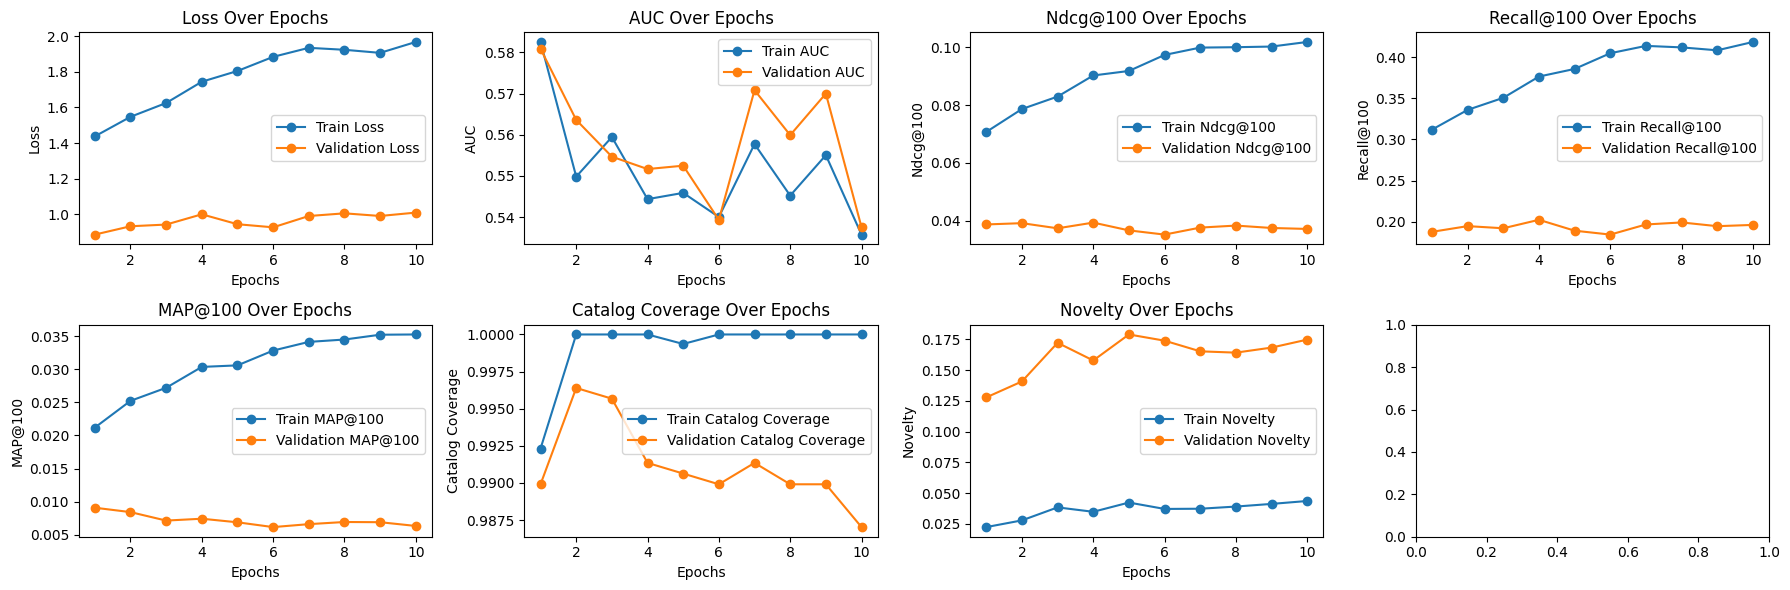

In [35]:
_history = train_evaluation_clbk.get_records()
_history_val = valid_evaluation_clbk.get_records()
AUC_TERM = [k for k in _history if k.startswith('auc')][0]
_metrics  = {
    'Loss': 'loss',
    'AUC': AUC_TERM,
    'Ndcg@100': 'ndcg_at_100',
    'Recall@100': 'recall_at_100',
    'MAP@100':'map_at_100',
    'Catalog Coverage': 'coverage',
    'Novelty':'novelty'
}
print('Plot for model', VERSION)
plot_metrics(_history, _history_val, _metrics)


Plot for model v10


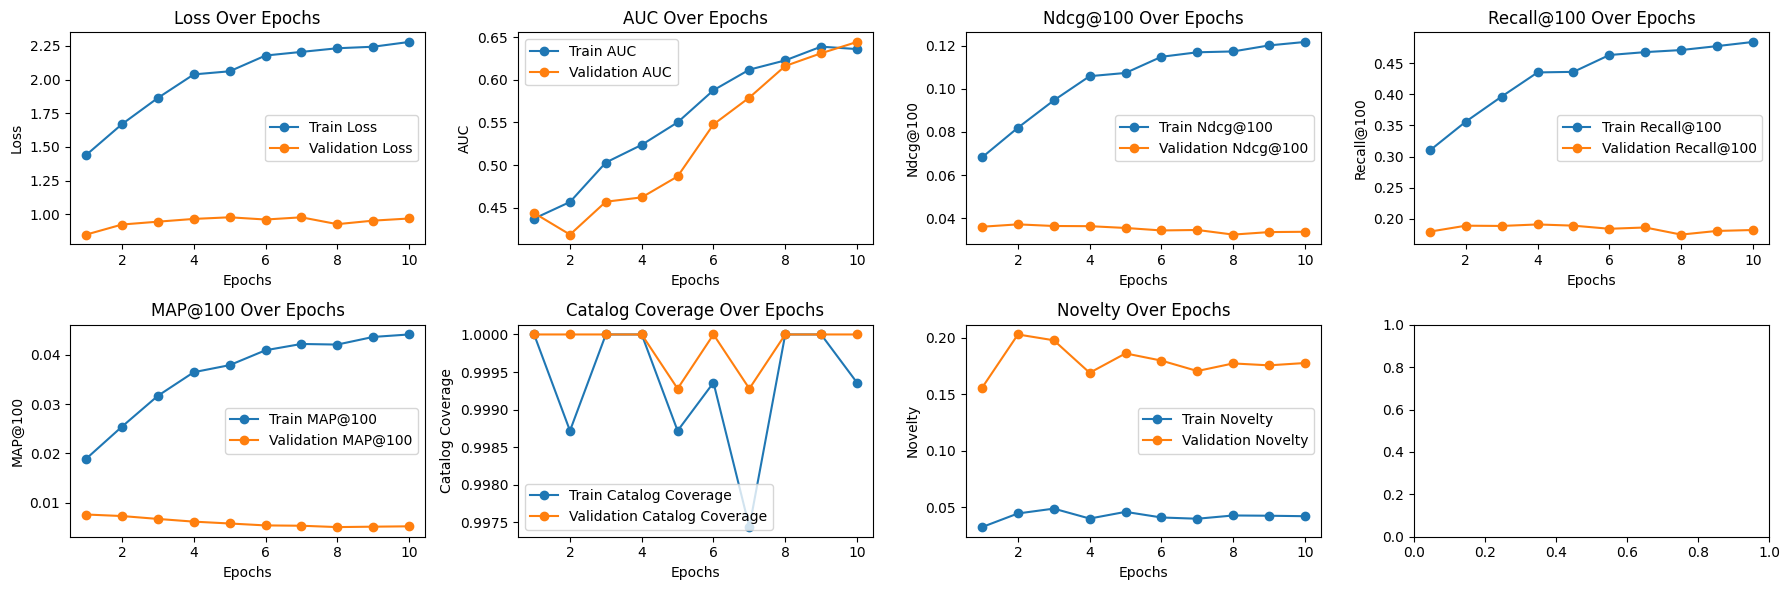

In [ ]:
_history = train_evaluation_clbk.get_records()
_history_val = valid_evaluation_clbk.get_records()
AUC_TERM = [k for k in _history if k.startswith('auc')][0]
_metrics  = {
    'Loss': 'loss',
    'AUC': AUC_TERM,
    'Ndcg@100': 'ndcg_at_100',
    'Recall@100': 'recall_at_100',
    'MAP@100':'map_at_100',
    'Catalog Coverage': 'coverage',
    'Novelty':'novelty'
}
print('Plot for model', VERSION)
plot_metrics(_history, _history_val, _metrics)


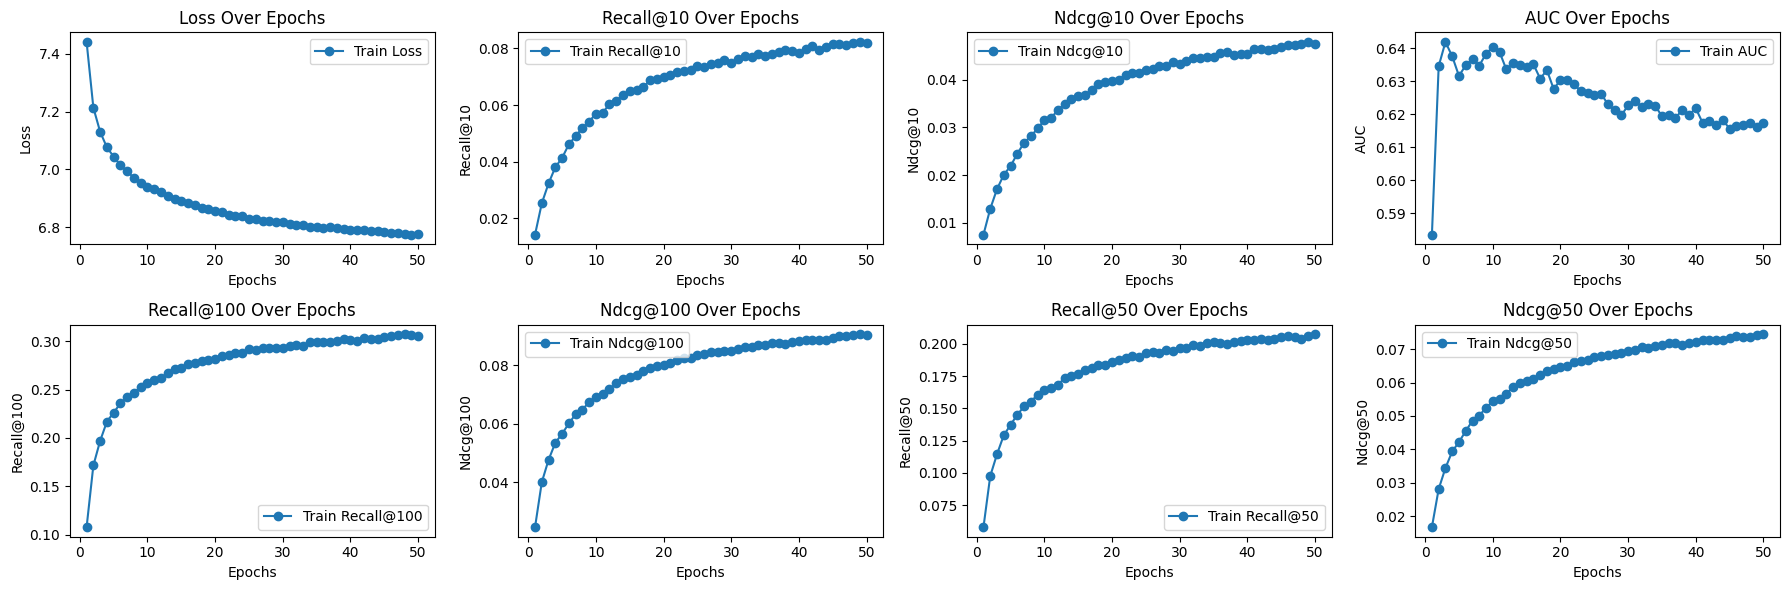

In [36]:
_history = merge_model_history(*history)
# AUC_TERM = [k for k in _history if k.startswith('auc')][0]
METRIC_AT = {'@'.join([k.split('_')[0].title(), k.split('_')[-1]]):k for k in _history if k.startswith('recall') or k.startswith('ndcg')}
val_history = { k[4:]:v for k,v in _history.items() if k.startswith('val')}
plot_metrics(_history, None, default_plot_metrics | {'AUC': 'auc', **METRIC_AT,})
# {'AUC': AUC_TERM, 'Recall@100': 'recall_at_100','NDCG@10': 'ndcg_at_10',}

### model_v2

In [39]:
VERSION = 'v2'

_tower_dim = [512, 256] # @param

_learning_rate = 0.01 # @param
_batch_size = 1024 * 2 # @param
_epochs = 50 # @param
_validation_batch_size = 2048 # @param
_sample_neg = _batch_size * 2 # @param
_validation_freq = 5 # @param
_loss = 'categorical_crossentropy' # @param
# _loss = 'bpr-max' # @param

_logq_sampling_correction = False # @param

embedding_dims = {
    'item': {
        'movie_id': 64,
        'genres': 8*2,
        'cast': 128
    },
    'user': {
        'user_id': 64,
        'gender': 8,
        'occupation': 8*2
    }
}

In [40]:
if VERSION in models:
    raise RuntimeError('Reusing model version: ', VERSION)

In [41]:
from merlin.models.tf.outputs.sampling.in_batch import InBatchSamplerV2

sampler = [InBatchSamplerV2(_sample_neg)]

models[VERSION] = model = build_towers(
    train,
    tower_dim=_tower_dim,
    neg_sampler=sampler,
    embedding_dims=embedding_dims,
    logq_sampling_correction=_logq_sampling_correction,
    item_categorical=item_embeddings_block  # needed to initiate the text embeddings
)

train_evaluation_clbks[VERSION] = EvaluationCallback(period=5, topk=100, data=train, type_='Train', schema=train.schema)
valid_evaluation_clbks[VERSION] = EvaluationCallback(period=5, topk=100, data=valid, type_='Validation', schema=train.schema)
historys[VERSION] = []

TOP_K = [100, 50, 10]
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
    run_eagerly=False,
    metrics=topk_metrics_aggregator(TOP_K),
    loss=_loss,
)

#### model

In [42]:
history = historys[VERSION]
model = models[VERSION]
train_evaluation_clbk = train_evaluation_clbks[VERSION]
valid_evaluation_clbk = valid_evaluation_clbks[VERSION]

In [43]:
# %pdb on
history.append(
    model.fit(train, validation_data=valid, batch_size=_batch_size, epochs=_epochs,
                 validation_batch_size=_validation_batch_size, validation_freq=_validation_freq,
                 callbacks=[train_evaluation_clbk,
                            valid_evaluation_clbk],
                  verbose=1)
)

Epoch 1/50
35/35 [==============================] - 32s 453ms/step - loss: 7.9621 - auc: 0.5043 - recall_at_100: 0.0548 - mrr_at_100: 0.0035 - ndcg_at_100: 0.0120 - map_at_100: 0.0035 - precision_at_100: 5.4776e-04 - recall_at_50: 0.0284 - mrr_at_50: 0.0031 - ndcg_at_50: 0.0078 - map_at_50: 0.0031 - precision_at_50: 5.6726e-04 - recall_at_10: 0.0064 - mrr_at_10: 0.0022 - ndcg_at_10: 0.0032 - map_at_10: 0.0022 - precision_at_10: 6.4250e-04 - regularization_loss: 0.0000e+00 - loss_batch: 7.8787
Epoch 2/50
35/35 [==============================] - 10s 232ms/step - loss: 7.3422 - auc: 0.6148 - recall_at_100: 0.1179 - mrr_at_100: 0.0078 - ndcg_at_100: 0.0264 - map_at_100: 0.0078 - precision_at_100: 0.0012 - recall_at_50: 0.0625 - mrr_at_50: 0.0071 - ndcg_at_50: 0.0175 - map_at_50: 0.0071 - precision_at_50: 0.0013 - recall_at_10: 0.0157 - mrr_at_10: 0.0052 - ndcg_at_10: 0.0076 - map_at_10: 0.0052 - precision_at_10: 0.0016 - regularization_loss: 0.0000e+00 - loss_batch: 7.2768
Epoch 3/50
35/35

69/69 [==============================] - 10s 36ms/step - loss: 1.4144 - auc: 0.5486 - recall_at_100: 0.3041 - mrr_at_100: 0.0185 - ndcg_at_100: 0.0670 - map_at_100: 0.0185 - precision_at_100: 0.0030 - recall_at_10: 0.0379 - mrr_at_10: 0.0111 - ndcg_at_10: 0.0172 - map_at_10: 0.0111 - precision_at_10: 0.0038 - regularization_loss: 0.0000e+00 - loss_batch: 1.4209
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.4143785238265991, 'auc': 0.5486200451850891, 'recall_at_100': 0.3056323230266571, 'mrr_at_100': 0.018615709617733955, 'ndcg_at_100': 0.0673319399356842, 'map_at_100': 0.018615709617733955, 'precision_at_100': 0.0030563233885914087, 'recall_at_10': 0.0384034626185894, 'mrr_at_10': 0.011255713179707527, 'ndcg_at_10': 0.017458263784646988, 'map_at_10': 0.011255713179707527, 'precision_at_10': 0.0038403465878218412, 'regularization_loss': 0.0, 'loss_batch': 1.7322700023651123, 'coverage': 0.9974375400384369, 'novelty': 0.02829877261951205}
Candidate set rows: 1387


15/15 [==============================] - 4s 23ms/step - loss: 0.9203 - auc: 0.5573 - recall_at_100: 0.1866 - mrr_at_100: 0.0078 - ndcg_at_100: 0.0373 - map_at_100: 0.0078 - precision_at_100: 0.0019 - recall_at_10: 0.0159 - mrr_at_10: 0.0037 - ndcg_at_10: 0.0064 - map_at_10: 0.0037 - precision_at_10: 0.0016 - regularization_loss: 0.0000e+00 - loss_batch: 0.9754
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9202835559844971, 'auc': 0.5573176145553589, 'recall_at_100': 0.19479738175868988, 'mrr_at_100': 0.008660365827381611, 'ndcg_at_100': 0.03947906568646431, 'map_at_100': 0.008660365827381611, 'precision_at_100': 0.0019479738548398018, 'recall_at_10': 0.016784807667136192, 'mrr_at_10': 0.004188957158476114, 'ndcg_at_10': 0.007032447494566441, 'map_at_10': 0.004188957158476114, 'precision_at_10': 0.001678480883128941, 'regularization_loss': 0.0, 'loss_batch': 1.551224946975708, 'coverage': 0.9826964671953857, 'novelty': 0.14773617421275265}
35/35 [================

69/69 [==============================] - 6s 22ms/step - loss: 1.6111 - auc: 0.5005 - recall_at_100: 0.3427 - mrr_at_100: 0.0231 - ndcg_at_100: 0.0777 - map_at_100: 0.0231 - precision_at_100: 0.0034 - recall_at_10: 0.0499 - mrr_at_10: 0.0151 - ndcg_at_10: 0.0230 - map_at_10: 0.0151 - precision_at_10: 0.0050 - regularization_loss: 0.0000e+00 - loss_batch: 1.6215
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.6110666990280151, 'auc': 0.5005435347557068, 'recall_at_100': 0.3433520495891571, 'mrr_at_100': 0.023533759638667107, 'ndcg_at_100': 0.07815767824649811, 'map_at_100': 0.023533759638667107, 'precision_at_100': 0.0034335206728428602, 'recall_at_10': 0.049699440598487854, 'mrr_at_10': 0.015382323414087296, 'ndcg_at_10': 0.023239772766828537, 'map_at_10': 0.015382323414087296, 'precision_at_10': 0.004969943314790726, 'regularization_loss': 0.0, 'loss_batch': 2.118807792663574, 'coverage': 1.0, 'novelty': 0.04268513489045809}
Candidate set rows: 1387


15/15 [==============================] - 4s 24ms/step - loss: 0.9140 - auc: 0.4830 - recall_at_100: 0.1835 - mrr_at_100: 0.0071 - ndcg_at_100: 0.0360 - map_at_100: 0.0071 - precision_at_100: 0.0018 - recall_at_10: 0.0122 - mrr_at_10: 0.0029 - ndcg_at_10: 0.0050 - map_at_10: 0.0029 - precision_at_10: 0.0012 - regularization_loss: 0.0000e+00 - loss_batch: 0.9708
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9139569401741028, 'auc': 0.4829624891281128, 'recall_at_100': 0.18811020255088806, 'mrr_at_100': 0.007910734973847866, 'ndcg_at_100': 0.037591367959976196, 'map_at_100': 0.007910734973847866, 'precision_at_100': 0.0018811019835993648, 'recall_at_10': 0.013775578700006008, 'mrr_at_10': 0.00355969974771142, 'ndcg_at_10': 0.005877070594578981, 'map_at_10': 0.00355969974771142, 'precision_at_10': 0.0013775578700006008, 'regularization_loss': 0.0, 'loss_batch': 1.5657973289489746, 'coverage': 0.989185291997116, 'novelty': 0.19391322229076702}
35/35 [================

69/69 [==============================] - 6s 23ms/step - loss: 1.7421 - auc: 0.5126 - recall_at_100: 0.3656 - mrr_at_100: 0.0280 - ndcg_at_100: 0.0859 - map_at_100: 0.0280 - precision_at_100: 0.0037 - recall_at_10: 0.0567 - mrr_at_10: 0.0192 - ndcg_at_10: 0.0278 - map_at_10: 0.0192 - precision_at_10: 0.0057 - regularization_loss: 0.0000e+00 - loss_batch: 1.7542
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.7420846223831177, 'auc': 0.512566328048706, 'recall_at_100': 0.36899232864379883, 'mrr_at_100': 0.027798723429441452, 'ndcg_at_100': 0.08640511333942413, 'map_at_100': 0.027798723429441452, 'precision_at_100': 0.0036899240221828222, 'recall_at_10': 0.05761944130063057, 'mrr_at_10': 0.01896095834672451, 'ndcg_at_10': 0.0278290044516325, 'map_at_10': 0.01896095834672451, 'precision_at_10': 0.005761943757534027, 'regularization_loss': 0.0, 'loss_batch': 2.327500581741333, 'coverage': 1.0, 'novelty': 0.03876192042091417}
Candidate set rows: 1387


15/15 [==============================] - 4s 25ms/step - loss: 0.9645 - auc: 0.4856 - recall_at_100: 0.1879 - mrr_at_100: 0.0065 - ndcg_at_100: 0.0360 - map_at_100: 0.0065 - precision_at_100: 0.0019 - recall_at_10: 0.0100 - mrr_at_10: 0.0022 - ndcg_at_10: 0.0040 - map_at_10: 0.0022 - precision_at_10: 0.0010 - regularization_loss: 0.0000e+00 - loss_batch: 1.0236
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9645382165908813, 'auc': 0.4855593144893646, 'recall_at_100': 0.19225625693798065, 'mrr_at_100': 0.0069499448873102665, 'ndcg_at_100': 0.037230368703603745, 'map_at_100': 0.0069499448873102665, 'precision_at_100': 0.001922562369145453, 'recall_at_10': 0.011435067281126976, 'mrr_at_10': 0.002617789898067713, 'ndcg_at_10': 0.004610342439264059, 'map_at_10': 0.002617789898067713, 'precision_at_10': 0.0011435069609433413, 'regularization_loss': 0.0, 'loss_batch': 1.641373634338379, 'coverage': 0.9949531362653208, 'novelty': 0.17283724340175954}
35/35 [=============

69/69 [==============================] - 6s 25ms/step - loss: 1.8868 - auc: 0.5658 - recall_at_100: 0.4041 - mrr_at_100: 0.0320 - ndcg_at_100: 0.0964 - map_at_100: 0.0320 - precision_at_100: 0.0040 - recall_at_10: 0.0682 - mrr_at_10: 0.0221 - ndcg_at_10: 0.0327 - map_at_10: 0.0221 - precision_at_10: 0.0068 - regularization_loss: 0.0000e+00 - loss_batch: 1.8989
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.8868452310562134, 'auc': 0.5657991170883179, 'recall_at_100': 0.4035924971103668, 'mrr_at_100': 0.03225003927946091, 'ndcg_at_100': 0.0966164618730545, 'map_at_100': 0.03225003927946091, 'precision_at_100': 0.004035924095660448, 'recall_at_10': 0.06887268275022507, 'mrr_at_10': 0.022432515397667885, 'ndcg_at_10': 0.03309432417154312, 'map_at_10': 0.022432515397667885, 'precision_at_10': 0.006887268275022507, 'regularization_loss': 0.0, 'loss_batch': 2.472519636154175, 'coverage': 1.0, 'novelty': 0.03306451612903226}
Candidate set rows: 1387


15/15 [==============================] - 4s 25ms/step - loss: 0.9949 - auc: 0.5350 - recall_at_100: 0.2012 - mrr_at_100: 0.0073 - ndcg_at_100: 0.0391 - map_at_100: 0.0073 - precision_at_100: 0.0020 - recall_at_10: 0.0117 - mrr_at_10: 0.0026 - ndcg_at_10: 0.0047 - map_at_10: 0.0026 - precision_at_10: 0.0012 - regularization_loss: 0.0000e+00 - loss_batch: 1.0438
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9949491024017334, 'auc': 0.5350228548049927, 'recall_at_100': 0.19981275498867035, 'mrr_at_100': 0.007380868308246136, 'ndcg_at_100': 0.03890456259250641, 'map_at_100': 0.007380868308246136, 'precision_at_100': 0.0019981274381279945, 'recall_at_10': 0.011501939035952091, 'mrr_at_10': 0.0027408127207309008, 'ndcg_at_10': 0.004714098293334246, 'map_at_10': 0.0027408127207309008, 'precision_at_10': 0.0011501939734444022, 'regularization_loss': 0.0, 'loss_batch': 1.554539680480957, 'coverage': 0.9920692141312184, 'novelty': 0.16425709806653893}
35/35 [=============

69/69 [==============================] - 9s 27ms/step - loss: 1.9702 - auc: 0.5351 - recall_at_100: 0.4229 - mrr_at_100: 0.0326 - ndcg_at_100: 0.1002 - map_at_100: 0.0326 - precision_at_100: 0.0042 - recall_at_10: 0.0695 - mrr_at_10: 0.0222 - ndcg_at_10: 0.0330 - map_at_10: 0.0222 - precision_at_10: 0.0070 - regularization_loss: 0.0000e+00 - loss_batch: 1.9832
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.9701577425003052, 'auc': 0.5351371765136719, 'recall_at_100': 0.42072874307632446, 'mrr_at_100': 0.03343869373202324, 'ndcg_at_100': 0.10052073746919632, 'map_at_100': 0.03343869373202324, 'precision_at_100': 0.004207286983728409, 'recall_at_10': 0.07143671065568924, 'mrr_at_10': 0.023202434182167053, 'ndcg_at_10': 0.03427375480532646, 'map_at_10': 0.023202434182167053, 'precision_at_10': 0.007143671158701181, 'regularization_loss': 0.0, 'loss_batch': 2.603492021560669, 'coverage': 1.0, 'novelty': 0.038010399451811845}
Candidate set rows: 1387


15/15 [==============================] - 4s 37ms/step - loss: 0.9833 - auc: 0.5003 - recall_at_100: 0.1928 - mrr_at_100: 0.0070 - ndcg_at_100: 0.0373 - map_at_100: 0.0070 - precision_at_100: 0.0019 - recall_at_10: 0.0124 - mrr_at_10: 0.0028 - ndcg_at_10: 0.0050 - map_at_10: 0.0028 - precision_at_10: 0.0012 - regularization_loss: 0.0000e+00 - loss_batch: 1.0176
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9833006858825684, 'auc': 0.5003486275672913, 'recall_at_100': 0.19653604924678802, 'mrr_at_100': 0.0074980310164391994, 'ndcg_at_100': 0.03846026957035065, 'map_at_100': 0.0074980310164391994, 'precision_at_100': 0.0019653604831546545, 'recall_at_10': 0.013775578700006008, 'mrr_at_10': 0.00318129057995975, 'ndcg_at_10': 0.005594618618488312, 'map_at_10': 0.00318129057995975, 'precision_at_10': 0.0013775578700006008, 'regularization_loss': 0.0, 'loss_batch': 1.3765709400177002, 'coverage': 0.9920692141312184, 'novelty': 0.15721907302434146}
35/35 [==============

69/69 [==============================] - 9s 22ms/step - loss: 1.9693 - auc: 0.5130 - recall_at_100: 0.4191 - mrr_at_100: 0.0337 - ndcg_at_100: 0.1006 - map_at_100: 0.0337 - precision_at_100: 0.0042 - recall_at_10: 0.0728 - mrr_at_10: 0.0236 - ndcg_at_10: 0.0348 - map_at_10: 0.0236 - precision_at_10: 0.0073 - regularization_loss: 0.0000e+00 - loss_batch: 1.9829
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.9693115949630737, 'auc': 0.513039231300354, 'recall_at_100': 0.41867753863334656, 'mrr_at_100': 0.03449686989188194, 'ndcg_at_100': 0.10129642486572266, 'map_at_100': 0.03449686989188194, 'precision_at_100': 0.00418677506968379, 'recall_at_10': 0.07485541701316833, 'mrr_at_10': 0.024358194321393967, 'ndcg_at_10': 0.035950787365436554, 'map_at_10': 0.024358194321393967, 'precision_at_10': 0.007485543377697468, 'regularization_loss': 0.0, 'loss_batch': 2.630314350128174, 'coverage': 1.0, 'novelty': 0.03777288203484879}
Candidate set rows: 1387


15/15 [==============================] - 5s 37ms/step - loss: 1.0154 - auc: 0.4725 - recall_at_100: 0.1951 - mrr_at_100: 0.0061 - ndcg_at_100: 0.0367 - map_at_100: 0.0061 - precision_at_100: 0.0020 - recall_at_10: 0.0095 - mrr_at_10: 0.0018 - ndcg_at_10: 0.0035 - map_at_10: 0.0018 - precision_at_10: 9.4724e-04 - regularization_loss: 0.0000e+00 - loss_batch: 1.0497
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 1.015442132949829, 'auc': 0.47247904539108276, 'recall_at_100': 0.19921091198921204, 'mrr_at_100': 0.006563376169651747, 'ndcg_at_100': 0.0378664955496788, 'map_at_100': 0.006563376169651747, 'precision_at_100': 0.0019921089988201857, 'recall_at_10': 0.01083322148770094, 'mrr_at_10': 0.00217667524702847, 'ndcg_at_10': 0.00411922438070178, 'map_at_10': 0.00217667524702847, 'precision_at_10': 0.001083322218619287, 'regularization_loss': 0.0, 'loss_batch': 1.408301830291748, 'coverage': 0.992790194664744, 'novelty': 0.1679729248307802}
35/35 [===================

69/69 [==============================] - 6s 22ms/step - loss: 2.0346 - auc: 0.5173 - recall_at_100: 0.4312 - mrr_at_100: 0.0353 - ndcg_at_100: 0.1042 - map_at_100: 0.0353 - precision_at_100: 0.0043 - recall_at_10: 0.0770 - mrr_at_10: 0.0248 - ndcg_at_10: 0.0368 - map_at_10: 0.0248 - precision_at_10: 0.0077 - regularization_loss: 0.0000e+00 - loss_batch: 2.0485
Candidate set rows: 943
Train dataset topk evaluation {'loss': 2.034564256668091, 'auc': 0.5173047184944153, 'recall_at_100': 0.4312555193901062, 'mrr_at_100': 0.03539734706282616, 'ndcg_at_100': 0.10425689816474915, 'map_at_100': 0.03539734706282616, 'precision_at_100': 0.004312554839998484, 'recall_at_10': 0.07655052840709686, 'mrr_at_10': 0.024867797270417213, 'ndcg_at_10': 0.036732159554958344, 'map_at_10': 0.024867797270417213, 'precision_at_10': 0.007655052002519369, 'regularization_loss': 0.0, 'loss_batch': 2.7119810581207275, 'coverage': 1.0, 'novelty': 0.03984282575629542}
Candidate set rows: 1387


15/15 [==============================] - 4s 26ms/step - loss: 0.9538 - auc: 0.4891 - recall_at_100: 0.1800 - mrr_at_100: 0.0058 - ndcg_at_100: 0.0340 - map_at_100: 0.0058 - precision_at_100: 0.0018 - recall_at_10: 0.0086 - mrr_at_10: 0.0019 - ndcg_at_10: 0.0034 - map_at_10: 0.0019 - precision_at_10: 8.5881e-04 - regularization_loss: 0.0000e+00 - loss_batch: 1.0076
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9537778496742249, 'auc': 0.4891389310359955, 'recall_at_100': 0.18543533980846405, 'mrr_at_100': 0.006290259771049023, 'ndcg_at_100': 0.035409703850746155, 'map_at_100': 0.006290259771049023, 'precision_at_100': 0.0018543533515185118, 'recall_at_10': 0.00936204381287098, 'mrr_at_10': 0.002115110866725445, 'ndcg_at_10': 0.003752518678084016, 'map_at_10': 0.002115110866725445, 'precision_at_10': 0.000936204451136291, 'regularization_loss': 0.0, 'loss_batch': 1.5699361562728882, 'coverage': 0.9942321557317952, 'novelty': 0.18006492266564827}
35/35 [===========

69/69 [==============================] - 7s 22ms/step - loss: 2.0771 - auc: 0.5334 - recall_at_100: 0.4351 - mrr_at_100: 0.0357 - ndcg_at_100: 0.1053 - map_at_100: 0.0357 - precision_at_100: 0.0044 - recall_at_10: 0.0779 - mrr_at_10: 0.0250 - ndcg_at_10: 0.0371 - map_at_10: 0.0250 - precision_at_10: 0.0078 - regularization_loss: 0.0000e+00 - loss_batch: 2.0901
Candidate set rows: 943
Train dataset topk evaluation {'loss': 2.07707142829895, 'auc': 0.5333614945411682, 'recall_at_100': 0.4376228451728821, 'mrr_at_100': 0.036221738904714584, 'ndcg_at_100': 0.10611896961927414, 'map_at_100': 0.036221738904714584, 'precision_at_100': 0.004376227967441082, 'recall_at_10': 0.07882966101169586, 'mrr_at_10': 0.025543762370944023, 'ndcg_at_10': 0.03777679428458214, 'map_at_10': 0.025543762370944023, 'precision_at_10': 0.007882964797317982, 'regularization_loss': 0.0, 'loss_batch': 2.709092140197754, 'coverage': 1.0, 'novelty': 0.04205878417554971}
Candidate set rows: 1387


15/15 [==============================] - 6s 38ms/step - loss: 0.9711 - auc: 0.4974 - recall_at_100: 0.1870 - mrr_at_100: 0.0058 - ndcg_at_100: 0.0351 - map_at_100: 0.0058 - precision_at_100: 0.0019 - recall_at_10: 0.0078 - mrr_at_10: 0.0016 - ndcg_at_10: 0.0030 - map_at_10: 0.0016 - precision_at_10: 7.8144e-04 - regularization_loss: 0.0000e+00 - loss_batch: 1.0207
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9711158275604248, 'auc': 0.4973844885826111, 'recall_at_100': 0.1879095882177353, 'mrr_at_100': 0.006057693623006344, 'ndcg_at_100': 0.035591814666986465, 'map_at_100': 0.006057693623006344, 'precision_at_100': 0.0018790957983583212, 'recall_at_10': 0.009094556793570518, 'mrr_at_10': 0.0018370621837675571, 'ndcg_at_10': 0.0034647854045033455, 'map_at_10': 0.0018370621837675571, 'precision_at_10': 0.0009094557026401162, 'regularization_loss': 0.0, 'loss_batch': 1.5393052101135254, 'coverage': 0.9920692141312184, 'novelty': 0.17622874229116053}
35/35 [=======

69/69 [==============================] - 6s 24ms/step - loss: 2.1198 - auc: 0.5215 - recall_at_100: 0.4482 - mrr_at_100: 0.0371 - ndcg_at_100: 0.1087 - map_at_100: 0.0371 - precision_at_100: 0.0045 - recall_at_10: 0.0806 - mrr_at_10: 0.0261 - ndcg_at_10: 0.0386 - map_at_10: 0.0261 - precision_at_10: 0.0081 - regularization_loss: 0.0000e+00 - loss_batch: 2.1330
Candidate set rows: 943
Train dataset topk evaluation {'loss': 2.119751453399658, 'auc': 0.5214800834655762, 'recall_at_100': 0.4498162567615509, 'mrr_at_100': 0.03781392425298691, 'ndcg_at_100': 0.10959799587726593, 'map_at_100': 0.03781392425298691, 'precision_at_100': 0.0044981627725064754, 'recall_at_10': 0.08169282972812653, 'mrr_at_10': 0.026845555752515793, 'ndcg_at_10': 0.039450909942388535, 'map_at_10': 0.026845555752515793, 'precision_at_10': 0.008169281296432018, 'regularization_loss': 0.0, 'loss_batch': 2.761209487915039, 'coverage': 0.9993593850096092, 'novelty': 0.040699179974104445}
Candidate set rows: 1387


15/15 [==============================] - 4s 25ms/step - loss: 0.9652 - auc: 0.4861 - recall_at_100: 0.1811 - mrr_at_100: 0.0058 - ndcg_at_100: 0.0340 - map_at_100: 0.0058 - precision_at_100: 0.0018 - recall_at_10: 0.0073 - mrr_at_10: 0.0018 - ndcg_at_10: 0.0030 - map_at_10: 0.0018 - precision_at_10: 7.3371e-04 - regularization_loss: 0.0000e+00 - loss_batch: 1.0108
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9652268886566162, 'auc': 0.4860715866088867, 'recall_at_100': 0.18683964014053345, 'mrr_at_100': 0.006152979098260403, 'ndcg_at_100': 0.03537529706954956, 'map_at_100': 0.006152979098260403, 'precision_at_100': 0.001868396415375173, 'recall_at_10': 0.008626454509794712, 'mrr_at_10': 0.002026213798671961, 'ndcg_at_10': 0.003519188379868865, 'map_at_10': 0.002026213798671961, 'precision_at_10': 0.0008626455091871321, 'regularization_loss': 0.0, 'loss_batch': 1.4868720769882202, 'coverage': 0.992790194664744, 'novelty': 0.1761628993087988}
35/35 [=============

69/69 [==============================] - 9s 28ms/step - loss: 2.1331 - auc: 0.5211 - recall_at_100: 0.4477 - mrr_at_100: 0.0369 - ndcg_at_100: 0.1084 - map_at_100: 0.0369 - precision_at_100: 0.0045 - recall_at_10: 0.0801 - mrr_at_10: 0.0260 - ndcg_at_10: 0.0385 - map_at_10: 0.0260 - precision_at_10: 0.0080 - regularization_loss: 0.0000e+00 - loss_batch: 2.1464
Candidate set rows: 943
Train dataset topk evaluation {'loss': 2.133091926574707, 'auc': 0.5210572481155396, 'recall_at_100': 0.4493746757507324, 'mrr_at_100': 0.037487152963876724, 'ndcg_at_100': 0.10917871445417404, 'map_at_100': 0.037487152963876724, 'precision_at_100': 0.0044937459751963615, 'recall_at_10': 0.0809093788266182, 'mrr_at_10': 0.02656646817922592, 'ndcg_at_10': 0.03905859589576721, 'map_at_10': 0.02656646817922592, 'precision_at_10': 0.008090936578810215, 'regularization_loss': 0.0, 'loss_batch': 2.7808117866516113, 'coverage': 1.0, 'novelty': 0.040340520191649555}
Candidate set rows: 1387


15/15 [==============================] - 5s 37ms/step - loss: 0.9223 - auc: 0.4938 - recall_at_100: 0.1717 - mrr_at_100: 0.0056 - ndcg_at_100: 0.0323 - map_at_100: 0.0056 - precision_at_100: 0.0017 - recall_at_10: 0.0077 - mrr_at_10: 0.0020 - ndcg_at_10: 0.0033 - map_at_10: 0.0020 - precision_at_10: 7.7137e-04 - regularization_loss: 0.0000e+00 - loss_batch: 0.9671
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9222579598426819, 'auc': 0.49375268816947937, 'recall_at_100': 0.176207035779953, 'mrr_at_100': 0.005938159301877022, 'ndcg_at_100': 0.033475421369075775, 'map_at_100': 0.005938159301877022, 'precision_at_100': 0.0017620703438296914, 'recall_at_10': 0.008960813283920288, 'mrr_at_10': 0.0021277419291436672, 'ndcg_at_10': 0.0036613454576581717, 'map_at_10': 0.0021277419291436672, 'precision_at_10': 0.0008960814448073506, 'regularization_loss': 0.0, 'loss_batch': 1.4355013370513916, 'coverage': 0.992790194664744, 'novelty': 0.17775683317624882}
35/35 [========

#### analysis

In [44]:
history = historys[VERSION]
model = models[VERSION]
train_evaluation_clbk = train_evaluation_clbks[VERSION]
valid_evaluation_clbk = valid_evaluation_clbks[VERSION]

Plot for model v2


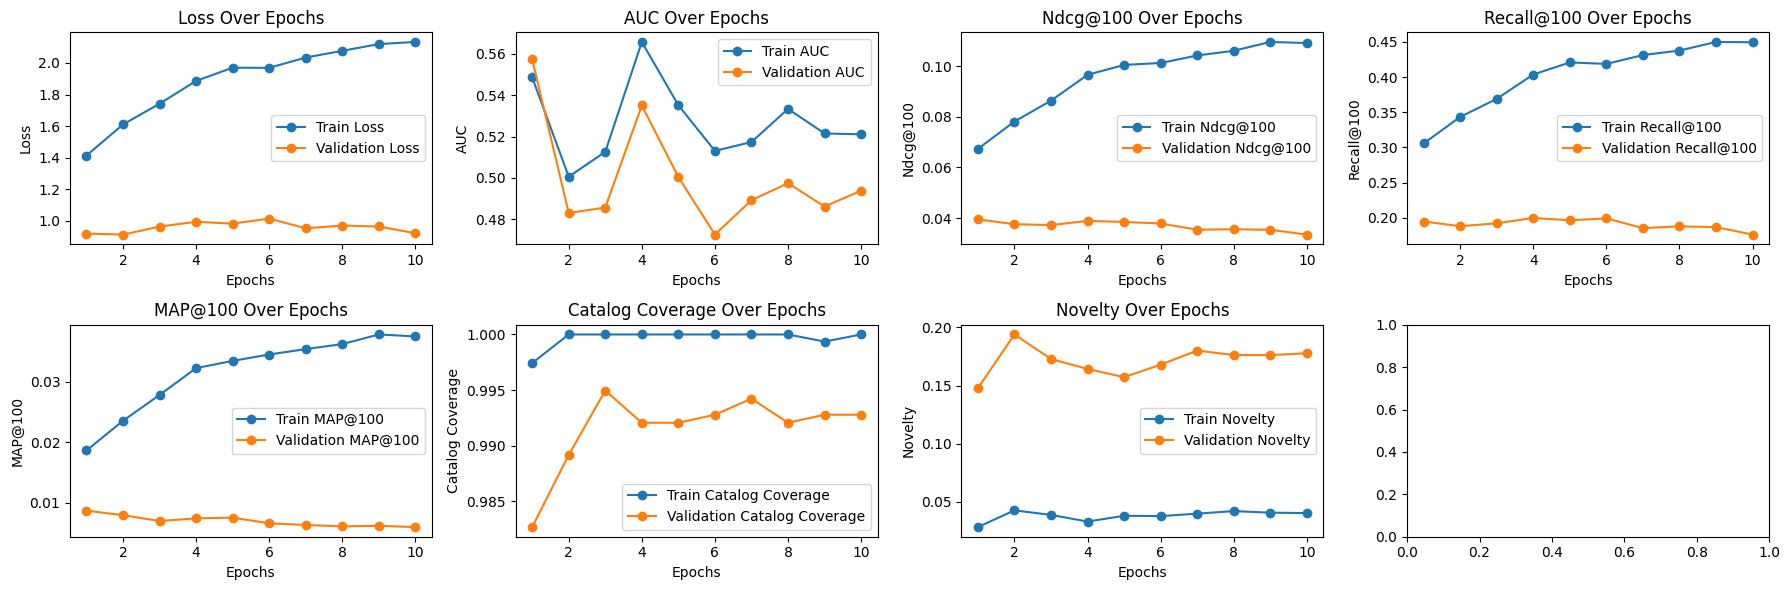

In [45]:
_history = train_evaluation_clbk.get_records()
_history_val = valid_evaluation_clbk.get_records()
AUC_TERM = [k for k in _history if k.startswith('auc')][0]
_metrics  = {
    'Loss': 'loss',
    'AUC': AUC_TERM,
    'Ndcg@100': 'ndcg_at_100',
    'Recall@100': 'recall_at_100',
    'MAP@100':'map_at_100',
    'Catalog Coverage': 'coverage',
    'Novelty':'novelty'
}
print('Plot for model', VERSION)
plot_metrics(_history, _history_val, _metrics)


Plot for model v10


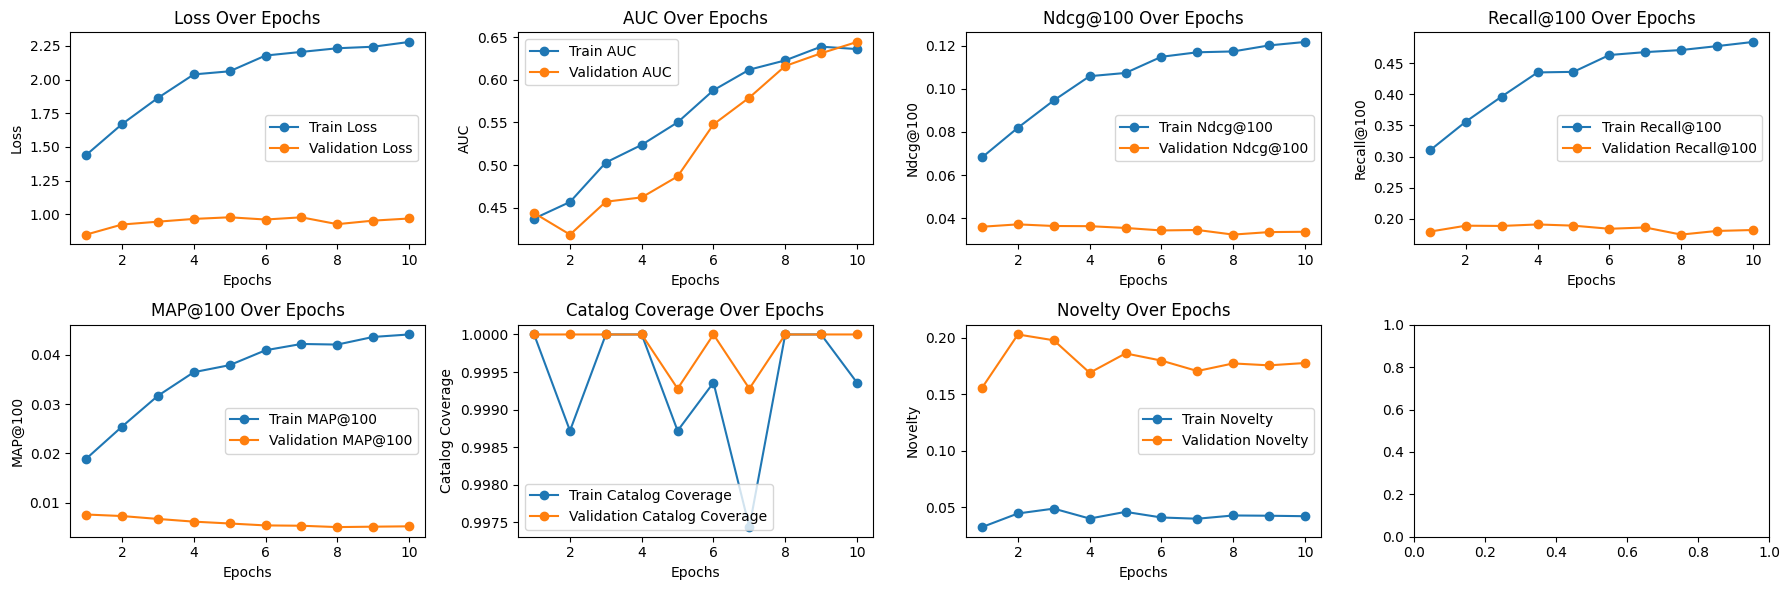

In [ ]:
_history = train_evaluation_clbk.get_records()
_history_val = valid_evaluation_clbk.get_records()
AUC_TERM = [k for k in _history if k.startswith('auc')][0]
_metrics  = {
    'Loss': 'loss',
    'AUC': AUC_TERM,
    'Ndcg@100': 'ndcg_at_100',
    'Recall@100': 'recall_at_100',
    'MAP@100':'map_at_100',
    'Catalog Coverage': 'coverage',
    'Novelty':'novelty'
}
print('Plot for model', VERSION)
plot_metrics(_history, _history_val, _metrics)


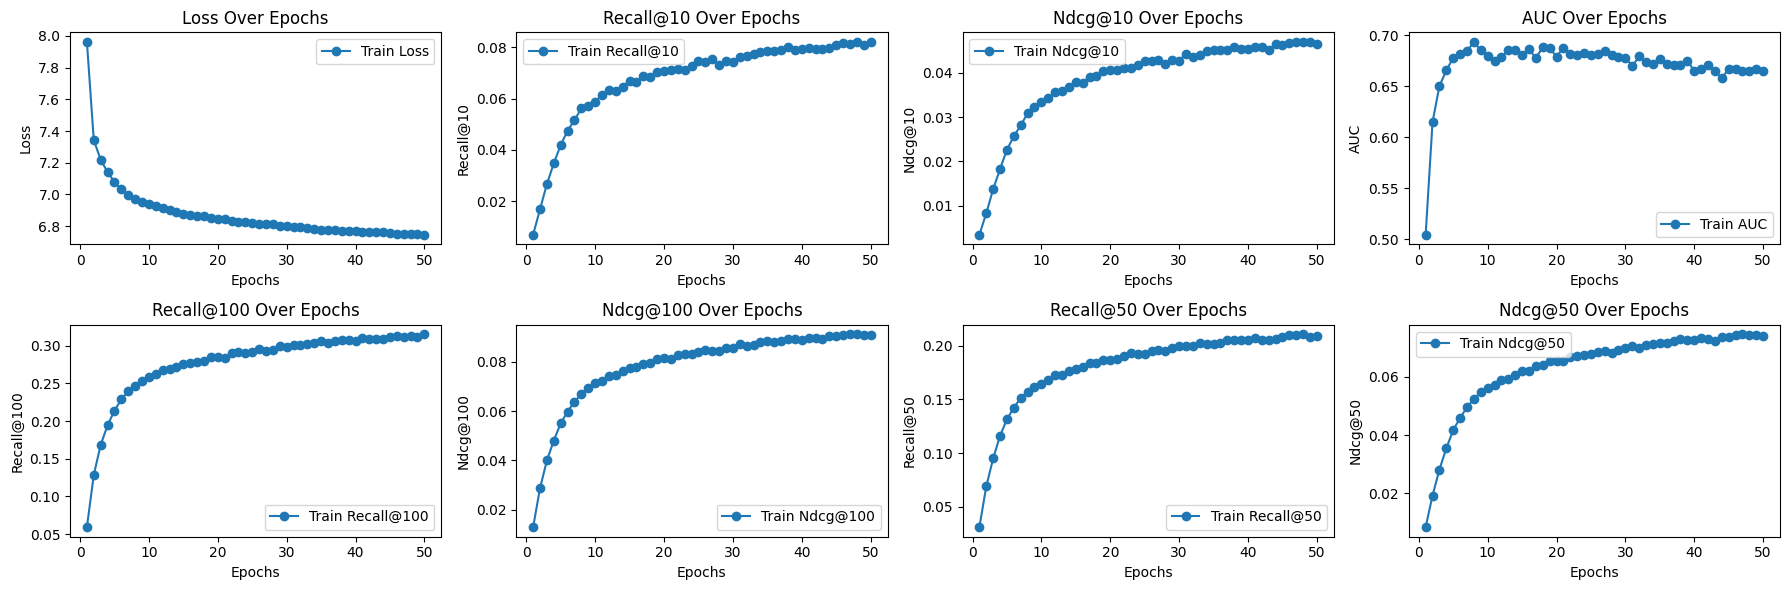

In [46]:
_history = merge_model_history(*history)
# AUC_TERM = [k for k in _history if k.startswith('auc')][0]
METRIC_AT = {'@'.join([k.split('_')[0].title(), k.split('_')[-1]]):k for k in _history if k.startswith('recall') or k.startswith('ndcg')}
val_history = { k[4:]:v for k,v in _history.items() if k.startswith('val')}
plot_metrics(_history, None, default_plot_metrics | {'AUC': 'auc', **METRIC_AT,})
# {'AUC': AUC_TERM, 'Recall@100': 'recall_at_100','NDCG@10': 'ndcg_at_10',}

### model_v3

In [53]:
VERSION = 'v3'

_tower_dim = {
    'user':[128, 128],
    'item':[512, 256, 128],
}

_learning_rate = 0.01 # @param
_batch_size = 1024 * 2 # @param
_epochs = 50 # @param
_validation_batch_size = 2048 # @param
_sample_neg = _batch_size * 2 # @param
_validation_freq = 5 # @param
_loss = 'categorical_crossentropy' # @param
# _loss = 'bpr-max' # @param

_logq_sampling_correction = False # @param

embedding_dims = {
    'item': {
        'movie_id': 64,
        'genres': 8*2,
        'cast': 128
    },
    'user': {
        'user_id': 64,
        'gender': 8,
        'occupation': 8*2
    }
}

In [54]:
if VERSION in models:
    raise RuntimeError('Reusing model version: ', VERSION)

RuntimeError: ignored

In [56]:
from merlin.models.tf.outputs.sampling.in_batch import InBatchSamplerV2

sampler = [InBatchSamplerV2(_sample_neg)]

models[VERSION] = model = build_towers(
    train,
    tower_dim=_tower_dim,
    neg_sampler=sampler,
    embedding_dims=embedding_dims,
    logq_sampling_correction=_logq_sampling_correction,
    item_categorical=item_embeddings_block  # needed to initiate the text embeddings
)

train_evaluation_clbks[VERSION] = EvaluationCallback(period=5, topk=100, data=train, type_='Train', schema=train.schema)
valid_evaluation_clbks[VERSION] = EvaluationCallback(period=5, topk=100, data=valid, type_='Validation', schema=train.schema)
historys[VERSION] = []

TOP_K = [100, 50, 10]
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
    run_eagerly=False,
    metrics=topk_metrics_aggregator(TOP_K),
    loss=_loss,
)

#### model

In [57]:
history = historys[VERSION]
model = models[VERSION]
train_evaluation_clbk = train_evaluation_clbks[VERSION]
valid_evaluation_clbk = valid_evaluation_clbks[VERSION]

In [58]:
# %pdb on
history.append(
    model.fit(train, validation_data=valid, batch_size=_batch_size, epochs=_epochs,
                 validation_batch_size=_validation_batch_size, validation_freq=_validation_freq,
                 callbacks=[train_evaluation_clbk,
                            valid_evaluation_clbk],
                  verbose=1)
)

Epoch 1/50
35/35 [==============================] - 33s 505ms/step - loss: 7.3833 - auc: 0.5689 - recall_at_100: 0.1007 - mrr_at_100: 0.0073 - ndcg_at_100: 0.0230 - map_at_100: 0.0073 - precision_at_100: 0.0010 - recall_at_50: 0.0543 - mrr_at_50: 0.0066 - ndcg_at_50: 0.0156 - map_at_50: 0.0066 - precision_at_50: 0.0011 - recall_at_10: 0.0145 - mrr_at_10: 0.0050 - ndcg_at_10: 0.0072 - map_at_10: 0.0050 - precision_at_10: 0.0014 - regularization_loss: 0.0000e+00 - loss_batch: 7.3088
Epoch 2/50
35/35 [==============================] - 11s 268ms/step - loss: 7.0970 - auc: 0.6180 - recall_at_100: 0.2029 - mrr_at_100: 0.0200 - ndcg_at_100: 0.0515 - map_at_100: 0.0200 - precision_at_100: 0.0020 - recall_at_50: 0.1238 - mrr_at_50: 0.0189 - ndcg_at_50: 0.0387 - map_at_50: 0.0189 - precision_at_50: 0.0025 - recall_at_10: 0.0382 - mrr_at_10: 0.0154 - ndcg_at_10: 0.0206 - map_at_10: 0.0154 - precision_at_10: 0.0038 - regularization_loss: 0.0000e+00 - loss_batch: 7.0302
Epoch 3/50
35/35 [==========

69/69 [==============================] - 6s 22ms/step - loss: 1.6359 - auc: 0.5653 - recall_at_100: 0.3519 - mrr_at_100: 0.0254 - ndcg_at_100: 0.0816 - map_at_100: 0.0254 - precision_at_100: 0.0035 - recall_at_10: 0.0548 - mrr_at_10: 0.0168 - ndcg_at_10: 0.0255 - map_at_10: 0.0168 - precision_at_10: 0.0055 - regularization_loss: 0.0000e+00 - loss_batch: 1.6448
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.635948896408081, 'auc': 0.565330982208252, 'recall_at_100': 0.35219794511795044, 'mrr_at_100': 0.025360343977808952, 'ndcg_at_100': 0.08159705251455307, 'map_at_100': 0.025360343977808952, 'precision_at_100': 0.0035219788551330566, 'recall_at_10': 0.05458533763885498, 'mrr_at_10': 0.016833636909723282, 'ndcg_at_10': 0.025482455268502235, 'map_at_10': 0.016833636909723282, 'precision_at_10': 0.005458532832562923, 'regularization_loss': 0.0, 'loss_batch': 2.0673227310180664, 'coverage': 1.0, 'novelty': 0.025462400432023764}
Candidate set rows: 1387


15/15 [==============================] - 4s 25ms/step - loss: 0.9369 - auc: 0.5801 - recall_at_100: 0.1889 - mrr_at_100: 0.0078 - ndcg_at_100: 0.0376 - map_at_100: 0.0078 - precision_at_100: 0.0019 - recall_at_10: 0.0134 - mrr_at_10: 0.0035 - ndcg_at_10: 0.0057 - map_at_10: 0.0035 - precision_at_10: 0.0013 - regularization_loss: 0.0000e+00 - loss_batch: 0.9985
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9369248747825623, 'auc': 0.5801243782043457, 'recall_at_100': 0.19245687127113342, 'mrr_at_100': 0.007856449112296104, 'ndcg_at_100': 0.03825749084353447, 'map_at_100': 0.007856449112296104, 'precision_at_100': 0.0019245685543864965, 'recall_at_10': 0.0141768092289567, 'mrr_at_10': 0.0034611434675753117, 'ndcg_at_10': 0.005880034063011408, 'map_at_10': 0.0034611434675753117, 'precision_at_10': 0.001417680992744863, 'regularization_loss': 0.0, 'loss_batch': 1.6427901983261108, 'coverage': 0.9805335255948089, 'novelty': 0.15620341229087295}
35/35 [===============

69/69 [==============================] - 9s 26ms/step - loss: 1.7737 - auc: 0.5285 - recall_at_100: 0.3756 - mrr_at_100: 0.0269 - ndcg_at_100: 0.0869 - map_at_100: 0.0269 - precision_at_100: 0.0038 - recall_at_10: 0.0588 - mrr_at_10: 0.0179 - ndcg_at_10: 0.0273 - map_at_10: 0.0179 - precision_at_10: 0.0059 - regularization_loss: 0.0000e+00 - loss_batch: 1.7866
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.7737200260162354, 'auc': 0.5284672975540161, 'recall_at_100': 0.3764992356300354, 'mrr_at_100': 0.028165556490421295, 'ndcg_at_100': 0.088175468146801, 'map_at_100': 0.028165556490421295, 'precision_at_100': 0.0037649923469871283, 'recall_at_10': 0.06063929945230484, 'mrr_at_10': 0.019135188311338425, 'ndcg_at_10': 0.028656454756855965, 'map_at_10': 0.019135188311338425, 'precision_at_10': 0.006063929293304682, 'regularization_loss': 0.0, 'loss_batch': 2.398569107055664, 'coverage': 1.0, 'novelty': 0.03813182369591589}
Candidate set rows: 1387


15/15 [==============================] - 5s 39ms/step - loss: 0.9696 - auc: 0.5328 - recall_at_100: 0.1857 - mrr_at_100: 0.0071 - ndcg_at_100: 0.0362 - map_at_100: 0.0071 - precision_at_100: 0.0019 - recall_at_10: 0.0116 - mrr_at_10: 0.0030 - ndcg_at_10: 0.0049 - map_at_10: 0.0030 - precision_at_10: 0.0012 - regularization_loss: 0.0000e+00 - loss_batch: 1.0256
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9695783257484436, 'auc': 0.532802402973175, 'recall_at_100': 0.19486424326896667, 'mrr_at_100': 0.007404153235256672, 'ndcg_at_100': 0.03809351101517677, 'map_at_100': 0.007404153235256672, 'precision_at_100': 0.0019486424280330539, 'recall_at_10': 0.012237528339028358, 'mrr_at_10': 0.0030101039446890354, 'ndcg_at_10': 0.005105634219944477, 'map_at_10': 0.0030101039446890354, 'precision_at_10': 0.001223752973601222, 'regularization_loss': 0.0, 'loss_batch': 1.6115323305130005, 'coverage': 0.9841384282624369, 'novelty': 0.16752531533131995}
35/35 [==============

69/69 [==============================] - 7s 22ms/step - loss: 1.7707 - auc: 0.5304 - recall_at_100: 0.3711 - mrr_at_100: 0.0285 - ndcg_at_100: 0.0875 - map_at_100: 0.0285 - precision_at_100: 0.0037 - recall_at_10: 0.0605 - mrr_at_10: 0.0196 - ndcg_at_10: 0.0290 - map_at_10: 0.0196 - precision_at_10: 0.0061 - regularization_loss: 0.0000e+00 - loss_batch: 1.7833
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.7707085609436035, 'auc': 0.5303856134414673, 'recall_at_100': 0.3739922046661377, 'mrr_at_100': 0.02896852232515812, 'ndcg_at_100': 0.08844352513551712, 'map_at_100': 0.02896852232515812, 'precision_at_100': 0.003739920910447836, 'recall_at_10': 0.06162217631936073, 'mrr_at_10': 0.020035438239574432, 'ndcg_at_10': 0.02957862988114357, 'map_at_10': 0.020035438239574432, 'precision_at_10': 0.006162217352539301, 'regularization_loss': 0.0, 'loss_batch': 2.379899501800537, 'coverage': 1.0, 'novelty': 0.04869107244281509}
Candidate set rows: 1387


15/15 [==============================] - 6s 38ms/step - loss: 0.9361 - auc: 0.5381 - recall_at_100: 0.1793 - mrr_at_100: 0.0057 - ndcg_at_100: 0.0338 - map_at_100: 0.0057 - precision_at_100: 0.0018 - recall_at_10: 0.0074 - mrr_at_10: 0.0016 - ndcg_at_10: 0.0029 - map_at_10: 0.0016 - precision_at_10: 7.3806e-04 - regularization_loss: 0.0000e+00 - loss_batch: 0.9962
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9361207485198975, 'auc': 0.5381256341934204, 'recall_at_100': 0.18496723473072052, 'mrr_at_100': 0.006291001569479704, 'ndcg_at_100': 0.035368919372558594, 'map_at_100': 0.006291001569479704, 'precision_at_100': 0.001849672175012529, 'recall_at_10': 0.008827069774270058, 'mrr_at_10': 0.0020674513652920723, 'ndcg_at_10': 0.0035920904483646154, 'map_at_10': 0.0020674513652920723, 'precision_at_10': 0.0008827070123516023, 'regularization_loss': 0.0, 'loss_batch': 1.6247341632843018, 'coverage': 0.9877433309300648, 'novelty': 0.19802603947921044}
35/35 [=======

69/69 [==============================] - 8s 36ms/step - loss: 1.9299 - auc: 0.5251 - recall_at_100: 0.4116 - mrr_at_100: 0.0334 - ndcg_at_100: 0.0992 - map_at_100: 0.0334 - precision_at_100: 0.0041 - recall_at_10: 0.0725 - mrr_at_10: 0.0234 - ndcg_at_10: 0.0346 - map_at_10: 0.0234 - precision_at_10: 0.0072 - regularization_loss: 0.0000e+00 - loss_batch: 1.9414
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.9298920631408691, 'auc': 0.5250973105430603, 'recall_at_100': 0.4132218360900879, 'mrr_at_100': 0.034292928874492645, 'ndcg_at_100': 0.10021757334470749, 'map_at_100': 0.034292928874492645, 'precision_at_100': 0.0041322181932628155, 'recall_at_10': 0.07428563386201859, 'mrr_at_10': 0.02426823414862156, 'ndcg_at_10': 0.0357578806579113, 'map_at_10': 0.02426823414862156, 'precision_at_10': 0.007428563199937344, 'regularization_loss': 0.0, 'loss_batch': 2.4886395931243896, 'coverage': 1.0, 'novelty': 0.03721535972216741}
Candidate set rows: 1387


15/15 [==============================] - 3s 24ms/step - loss: 0.9813 - auc: 0.5365 - recall_at_100: 0.1938 - mrr_at_100: 0.0069 - ndcg_at_100: 0.0372 - map_at_100: 0.0069 - precision_at_100: 0.0019 - recall_at_10: 0.0102 - mrr_at_10: 0.0027 - ndcg_at_10: 0.0044 - map_at_10: 0.0027 - precision_at_10: 0.0010 - regularization_loss: 0.0000e+00 - loss_batch: 1.0238
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.981310248374939, 'auc': 0.5365039706230164, 'recall_at_100': 0.19452989101409912, 'mrr_at_100': 0.006807334721088409, 'ndcg_at_100': 0.03738019987940788, 'map_at_100': 0.006807334721088409, 'precision_at_100': 0.0019452989799901843, 'recall_at_10': 0.010298248380422592, 'mrr_at_10': 0.0024225881788879633, 'ndcg_at_10': 0.0042109075002372265, 'map_at_10': 0.0024225881788879633, 'precision_at_10': 0.0010298248380422592, 'regularization_loss': 0.0, 'loss_batch': 1.4682735204696655, 'coverage': 0.9870223503965393, 'novelty': 0.16860361165742893}
35/35 [============

69/69 [==============================] - 9s 36ms/step - loss: 1.9498 - auc: 0.5537 - recall_at_100: 0.4146 - mrr_at_100: 0.0342 - ndcg_at_100: 0.1002 - map_at_100: 0.0342 - precision_at_100: 0.0041 - recall_at_10: 0.0738 - mrr_at_10: 0.0242 - ndcg_at_10: 0.0356 - map_at_10: 0.0242 - precision_at_10: 0.0074 - regularization_loss: 0.0000e+00 - loss_batch: 1.9622
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.9498282670974731, 'auc': 0.553683876991272, 'recall_at_100': 0.4126235842704773, 'mrr_at_100': 0.034680381417274475, 'ndcg_at_100': 0.10033991932868958, 'map_at_100': 0.034680381417274475, 'precision_at_100': 0.004126235842704773, 'recall_at_10': 0.0743710994720459, 'mrr_at_10': 0.024758033454418182, 'ndcg_at_10': 0.036173827946186066, 'map_at_10': 0.024758033454418182, 'precision_at_10': 0.0074371094815433025, 'regularization_loss': 0.0, 'loss_batch': 2.548804998397827, 'coverage': 1.0, 'novelty': 0.04290459074571182}
Candidate set rows: 1387


15/15 [==============================] - 5s 27ms/step - loss: 0.9547 - auc: 0.5820 - recall_at_100: 0.1807 - mrr_at_100: 0.0058 - ndcg_at_100: 0.0342 - map_at_100: 0.0058 - precision_at_100: 0.0018 - recall_at_10: 0.0078 - mrr_at_10: 0.0018 - ndcg_at_10: 0.0031 - map_at_10: 0.0018 - precision_at_10: 7.8158e-04 - regularization_loss: 0.0000e+00 - loss_batch: 1.0052
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9547443985939026, 'auc': 0.5820333957672119, 'recall_at_100': 0.18523472547531128, 'mrr_at_100': 0.005949672777205706, 'ndcg_at_100': 0.03506045788526535, 'map_at_100': 0.005949672777205706, 'precision_at_100': 0.00185234728269279, 'recall_at_10': 0.008760198019444942, 'mrr_at_10': 0.0017875719349831343, 'ndcg_at_10': 0.0033423525746911764, 'map_at_10': 0.0017875719349831343, 'precision_at_10': 0.0008760197670198977, 'regularization_loss': 0.0, 'loss_batch': 1.5333625078201294, 'coverage': 0.9877433309300648, 'novelty': 0.1815206929740135}
35/35 [==========

69/69 [==============================] - 9s 36ms/step - loss: 2.0557 - auc: 0.5334 - recall_at_100: 0.4357 - mrr_at_100: 0.0363 - ndcg_at_100: 0.1059 - map_at_100: 0.0363 - precision_at_100: 0.0044 - recall_at_10: 0.0799 - mrr_at_10: 0.0257 - ndcg_at_10: 0.0381 - map_at_10: 0.0257 - precision_at_10: 0.0080 - regularization_loss: 0.0000e+00 - loss_batch: 2.0689
Candidate set rows: 943
Train dataset topk evaluation {'loss': 2.055673360824585, 'auc': 0.5333872437477112, 'recall_at_100': 0.43806445598602295, 'mrr_at_100': 0.03716392070055008, 'ndcg_at_100': 0.1071302518248558, 'map_at_100': 0.03716392070055008, 'precision_at_100': 0.004380643833428621, 'recall_at_10': 0.08093786239624023, 'mrr_at_10': 0.026484787464141846, 'ndcg_at_10': 0.03900858387351036, 'map_at_10': 0.026484787464141846, 'precision_at_10': 0.008093786425888538, 'regularization_loss': 0.0, 'loss_batch': 2.696908950805664, 'coverage': 1.0, 'novelty': 0.035848697966166125}
Candidate set rows: 1387


15/15 [==============================] - 4s 34ms/step - loss: 1.0152 - auc: 0.5371 - recall_at_100: 0.1953 - mrr_at_100: 0.0065 - ndcg_at_100: 0.0371 - map_at_100: 0.0065 - precision_at_100: 0.0020 - recall_at_10: 0.0096 - mrr_at_10: 0.0021 - ndcg_at_10: 0.0038 - map_at_10: 0.0021 - precision_at_10: 9.6059e-04 - regularization_loss: 0.0000e+00 - loss_batch: 1.0530
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 1.0151697397232056, 'auc': 0.5371431112289429, 'recall_at_100': 0.1980072259902954, 'mrr_at_100': 0.0064941453747451305, 'ndcg_at_100': 0.037569861859083176, 'map_at_100': 0.0064941453747451305, 'precision_at_100': 0.0019800723530352116, 'recall_at_10': 0.009897017851471901, 'mrr_at_10': 0.0021053189411759377, 'ndcg_at_10': 0.0038590512704104185, 'map_at_10': 0.0021053189411759377, 'precision_at_10': 0.0009897018317133188, 'regularization_loss': 0.0, 'loss_batch': 1.4485188722610474, 'coverage': 0.9826964671953857, 'novelty': 0.15894151356817798}
35/35 [=====

69/69 [==============================] - 9s 34ms/step - loss: 2.0368 - auc: 0.5328 - recall_at_100: 0.4303 - mrr_at_100: 0.0354 - ndcg_at_100: 0.1042 - map_at_100: 0.0354 - precision_at_100: 0.0043 - recall_at_10: 0.0789 - mrr_at_10: 0.0250 - ndcg_at_10: 0.0374 - map_at_10: 0.0250 - precision_at_10: 0.0079 - regularization_loss: 0.0000e+00 - loss_batch: 2.0492
Candidate set rows: 943
Train dataset topk evaluation {'loss': 2.036775827407837, 'auc': 0.5328189730644226, 'recall_at_100': 0.4309706389904022, 'mrr_at_100': 0.036516427993774414, 'ndcg_at_100': 0.10526955872774124, 'map_at_100': 0.036516427993774414, 'precision_at_100': 0.004309705924242735, 'recall_at_10': 0.07982678711414337, 'mrr_at_10': 0.026104075834155083, 'ndcg_at_10': 0.038447897881269455, 'map_at_10': 0.026104075834155083, 'precision_at_10': 0.007982680574059486, 'regularization_loss': 0.0, 'loss_batch': 2.641695022583008, 'coverage': 1.0, 'novelty': 0.04279361045561808}
Candidate set rows: 1387


15/15 [==============================] - 5s 41ms/step - loss: 0.9927 - auc: 0.5494 - recall_at_100: 0.1895 - mrr_at_100: 0.0066 - ndcg_at_100: 0.0363 - map_at_100: 0.0066 - precision_at_100: 0.0019 - recall_at_10: 0.0096 - mrr_at_10: 0.0024 - ndcg_at_10: 0.0040 - map_at_10: 0.0024 - precision_at_10: 9.6164e-04 - regularization_loss: 0.0000e+00 - loss_batch: 1.0285
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9927406311035156, 'auc': 0.5493918061256409, 'recall_at_100': 0.19225625693798065, 'mrr_at_100': 0.0063546327874064445, 'ndcg_at_100': 0.03655141219496727, 'map_at_100': 0.0063546327874064445, 'precision_at_100': 0.0019225624855607748, 'recall_at_10': 0.009027685038745403, 'mrr_at_10': 0.0020175629761070013, 'ndcg_at_10': 0.003586740465834737, 'map_at_10': 0.0020175629761070013, 'precision_at_10': 0.0009027685737237334, 'regularization_loss': 0.0, 'loss_batch': 1.4028337001800537, 'coverage': 0.9906272530641672, 'novelty': 0.17944814462416747}
35/35 [======

69/69 [==============================] - 7s 23ms/step - loss: 2.1098 - auc: 0.5203 - recall_at_100: 0.4452 - mrr_at_100: 0.0378 - ndcg_at_100: 0.1091 - map_at_100: 0.0378 - precision_at_100: 0.0045 - recall_at_10: 0.0838 - mrr_at_10: 0.0269 - ndcg_at_10: 0.0400 - map_at_10: 0.0269 - precision_at_10: 0.0084 - regularization_loss: 0.0000e+00 - loss_batch: 2.1216
Candidate set rows: 943
Train dataset topk evaluation {'loss': 2.1098239421844482, 'auc': 0.5202866792678833, 'recall_at_100': 0.44689610600471497, 'mrr_at_100': 0.038496535271406174, 'ndcg_at_100': 0.10994207859039307, 'map_at_100': 0.038496535271406174, 'precision_at_100': 0.004468961618840694, 'recall_at_10': 0.0844847708940506, 'mrr_at_10': 0.027560202404856682, 'ndcg_at_10': 0.0406506173312664, 'map_at_10': 0.027560202404856682, 'precision_at_10': 0.00844847597181797, 'regularization_loss': 0.0, 'loss_batch': 2.682171106338501, 'coverage': 1.0, 'novelty': 0.03805027639914457}
Candidate set rows: 1387


15/15 [==============================] - 4s 25ms/step - loss: 0.9668 - auc: 0.5275 - recall_at_100: 0.1840 - mrr_at_100: 0.0056 - ndcg_at_100: 0.0345 - map_at_100: 0.0056 - precision_at_100: 0.0018 - recall_at_10: 0.0071 - mrr_at_10: 0.0014 - ndcg_at_10: 0.0027 - map_at_10: 0.0014 - precision_at_10: 7.0850e-04 - regularization_loss: 0.0000e+00 - loss_batch: 0.9989
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9668462872505188, 'auc': 0.5274742841720581, 'recall_at_100': 0.1865052878856659, 'mrr_at_100': 0.005804101005196571, 'ndcg_at_100': 0.03511127457022667, 'map_at_100': 0.005804101005196571, 'precision_at_100': 0.0018650527345016599, 'recall_at_10': 0.00795773696154356, 'mrr_at_10': 0.001610016799531877, 'ndcg_at_10': 0.0030318608041852713, 'map_at_10': 0.001610016799531877, 'precision_at_10': 0.000795773696154356, 'regularization_loss': 0.0, 'loss_batch': 1.3344643115997314, 'coverage': 0.9834174477289113, 'novelty': 0.16183284709112752}
35/35 [============

69/69 [==============================] - 7s 24ms/step - loss: 2.0833 - auc: 0.5161 - recall_at_100: 0.4387 - mrr_at_100: 0.0375 - ndcg_at_100: 0.1076 - map_at_100: 0.0375 - precision_at_100: 0.0044 - recall_at_10: 0.0833 - mrr_at_10: 0.0268 - ndcg_at_10: 0.0398 - map_at_10: 0.0268 - precision_at_10: 0.0083 - regularization_loss: 0.0000e+00 - loss_batch: 2.0949
Candidate set rows: 943
Train dataset topk evaluation {'loss': 2.0833492279052734, 'auc': 0.5160784721374512, 'recall_at_100': 0.4405287504196167, 'mrr_at_100': 0.03856515511870384, 'ndcg_at_100': 0.10892762243747711, 'map_at_100': 0.03856515511870384, 'precision_at_100': 0.0044052875600755215, 'recall_at_10': 0.08558160811662674, 'mrr_at_10': 0.027921410277485847, 'ndcg_at_10': 0.04117982089519501, 'map_at_10': 0.027921410277485847, 'precision_at_10': 0.008558161556720734, 'regularization_loss': 0.0, 'loss_batch': 2.644331693649292, 'coverage': 1.0, 'novelty': 0.04047210300429185}
Candidate set rows: 1387


15/15 [==============================] - 5s 24ms/step - loss: 0.9518 - auc: 0.5229 - recall_at_100: 0.1790 - mrr_at_100: 0.0055 - ndcg_at_100: 0.0334 - map_at_100: 0.0055 - precision_at_100: 0.0018 - recall_at_10: 0.0066 - mrr_at_10: 0.0015 - ndcg_at_10: 0.0027 - map_at_10: 0.0015 - precision_at_10: 6.5727e-04 - regularization_loss: 0.0000e+00 - loss_batch: 1.0024
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.951804518699646, 'auc': 0.5228888988494873, 'recall_at_100': 0.181690514087677, 'mrr_at_100': 0.005623241420835257, 'ndcg_at_100': 0.03415035456418991, 'map_at_100': 0.005623241420835257, 'precision_at_100': 0.0018169052200391889, 'recall_at_10': 0.0066871740855276585, 'mrr_at_10': 0.0014519925462082028, 'ndcg_at_10': 0.002629911992698908, 'map_at_10': 0.0014519925462082028, 'precision_at_10': 0.0006687174900434911, 'regularization_loss': 0.0, 'loss_batch': 1.5309640169143677, 'coverage': 0.9877433309300648, 'novelty': 0.1743390645220928}
35/35 [===========

69/69 [==============================] - 7s 32ms/step - loss: 2.0750 - auc: 0.5387 - recall_at_100: 0.4413 - mrr_at_100: 0.0384 - ndcg_at_100: 0.1089 - map_at_100: 0.0384 - precision_at_100: 0.0044 - recall_at_10: 0.0849 - mrr_at_10: 0.0276 - ndcg_at_10: 0.0408 - map_at_10: 0.0276 - precision_at_10: 0.0085 - regularization_loss: 0.0000e+00 - loss_batch: 2.0874
Candidate set rows: 943
Train dataset topk evaluation {'loss': 2.0750458240509033, 'auc': 0.5387058854103088, 'recall_at_100': 0.43974530696868896, 'mrr_at_100': 0.0390460379421711, 'ndcg_at_100': 0.10925523936748505, 'map_at_100': 0.0390460379421711, 'precision_at_100': 0.0043974523432552814, 'recall_at_10': 0.08592347800731659, 'mrr_at_10': 0.028361419215798378, 'ndcg_at_10': 0.04159120097756386, 'map_at_10': 0.028361419215798378, 'precision_at_10': 0.008592347614467144, 'regularization_loss': 0.0, 'loss_batch': 2.673429250717163, 'coverage': 1.0, 'novelty': 0.036863296978226025}
Candidate set rows: 1387


15/15 [==============================] - 4s 25ms/step - loss: 0.9348 - auc: 0.5523 - recall_at_100: 0.1739 - mrr_at_100: 0.0050 - ndcg_at_100: 0.0322 - map_at_100: 0.0050 - precision_at_100: 0.0017 - recall_at_10: 0.0054 - mrr_at_10: 0.0010 - ndcg_at_10: 0.0020 - map_at_10: 0.0010 - precision_at_10: 5.3894e-04 - regularization_loss: 0.0000e+00 - loss_batch: 0.9779
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9348215460777283, 'auc': 0.5523324012756348, 'recall_at_100': 0.17747759819030762, 'mrr_at_100': 0.005218330770730972, 'ndcg_at_100': 0.03302472457289696, 'map_at_100': 0.005218330770730972, 'precision_at_100': 0.001774776028469205, 'recall_at_10': 0.006152200046926737, 'mrr_at_10': 0.0012509261723607779, 'ndcg_at_10': 0.0023561788257211447, 'map_at_10': 0.0012509261723607779, 'precision_at_10': 0.0006152199930511415, 'regularization_loss': 0.0, 'loss_batch': 1.4280250072479248, 'coverage': 0.9863013698630136, 'novelty': 0.17217454811027935}
35/35 [========

#### analysis

In [59]:
history = historys[VERSION]
model = models[VERSION]
train_evaluation_clbk = train_evaluation_clbks[VERSION]
valid_evaluation_clbk = valid_evaluation_clbks[VERSION]

Plot for model v3


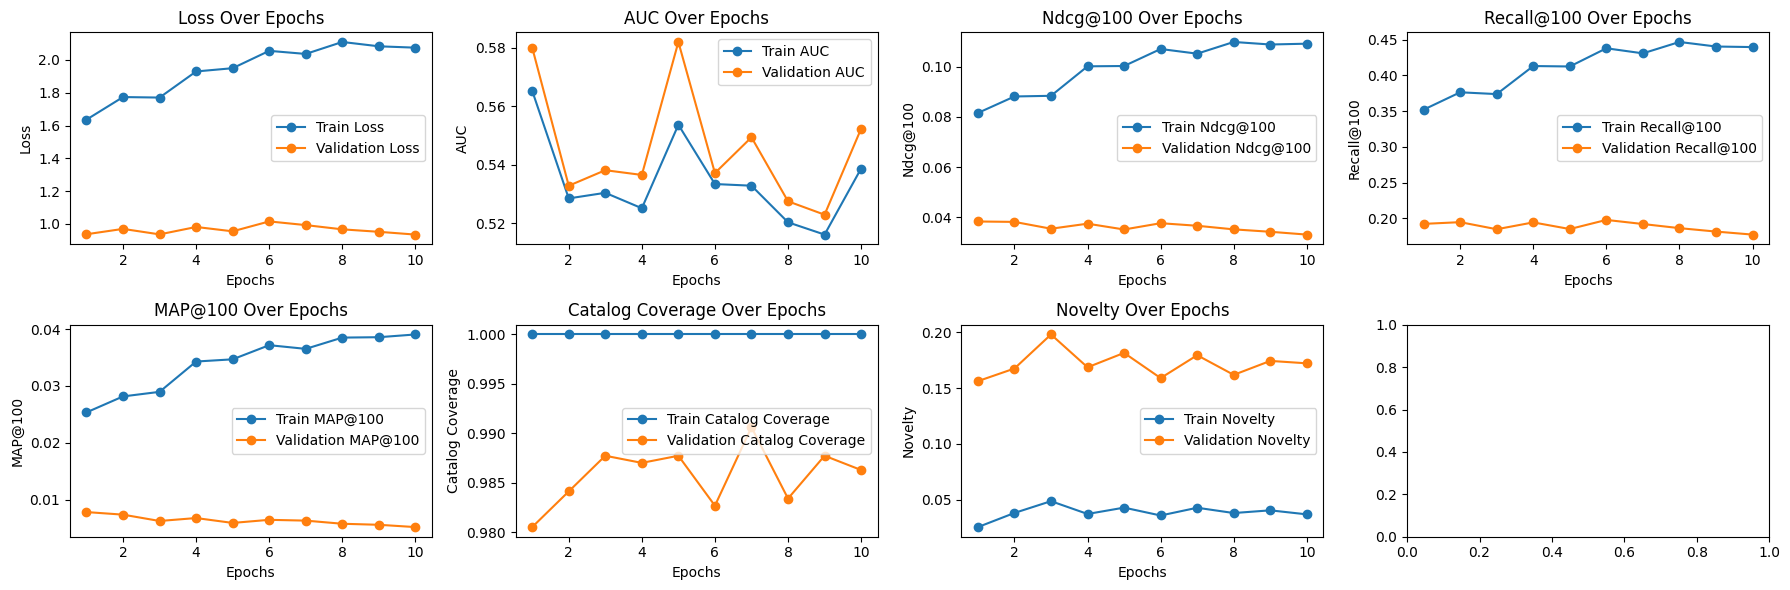

In [60]:
_history = train_evaluation_clbk.get_records()
_history_val = valid_evaluation_clbk.get_records()
AUC_TERM = [k for k in _history if k.startswith('auc')][0]
_metrics  = {
    'Loss': 'loss',
    'AUC': AUC_TERM,
    'Ndcg@100': 'ndcg_at_100',
    'Recall@100': 'recall_at_100',
    'MAP@100':'map_at_100',
    'Catalog Coverage': 'coverage',
    'Novelty':'novelty'
}
print('Plot for model', VERSION)
plot_metrics(_history, _history_val, _metrics)


Plot for model v10


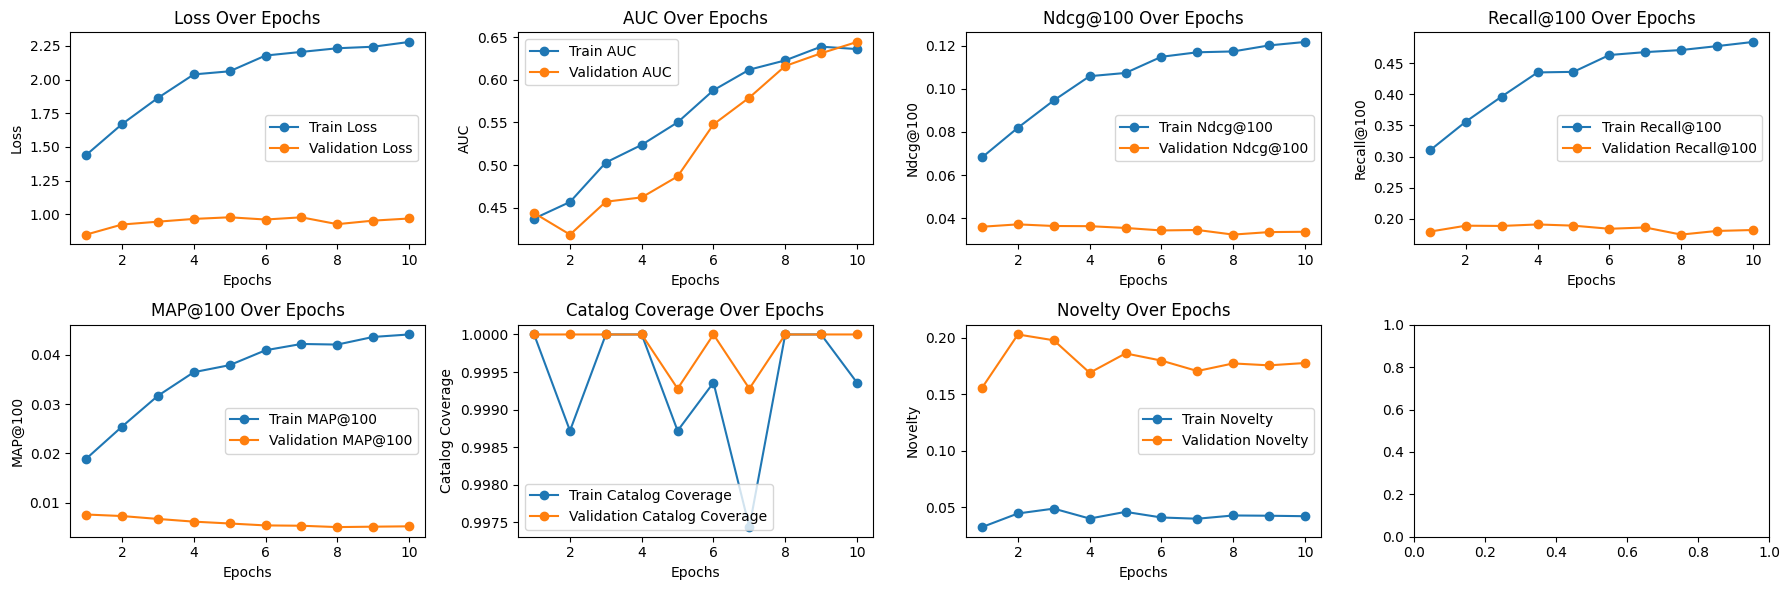

In [ ]:
_history = train_evaluation_clbk.get_records()
_history_val = valid_evaluation_clbk.get_records()
AUC_TERM = [k for k in _history if k.startswith('auc')][0]
_metrics  = {
    'Loss': 'loss',
    'AUC': AUC_TERM,
    'Ndcg@100': 'ndcg_at_100',
    'Recall@100': 'recall_at_100',
    'MAP@100':'map_at_100',
    'Catalog Coverage': 'coverage',
    'Novelty':'novelty'
}
print('Plot for model', VERSION)
plot_metrics(_history, _history_val, _metrics)


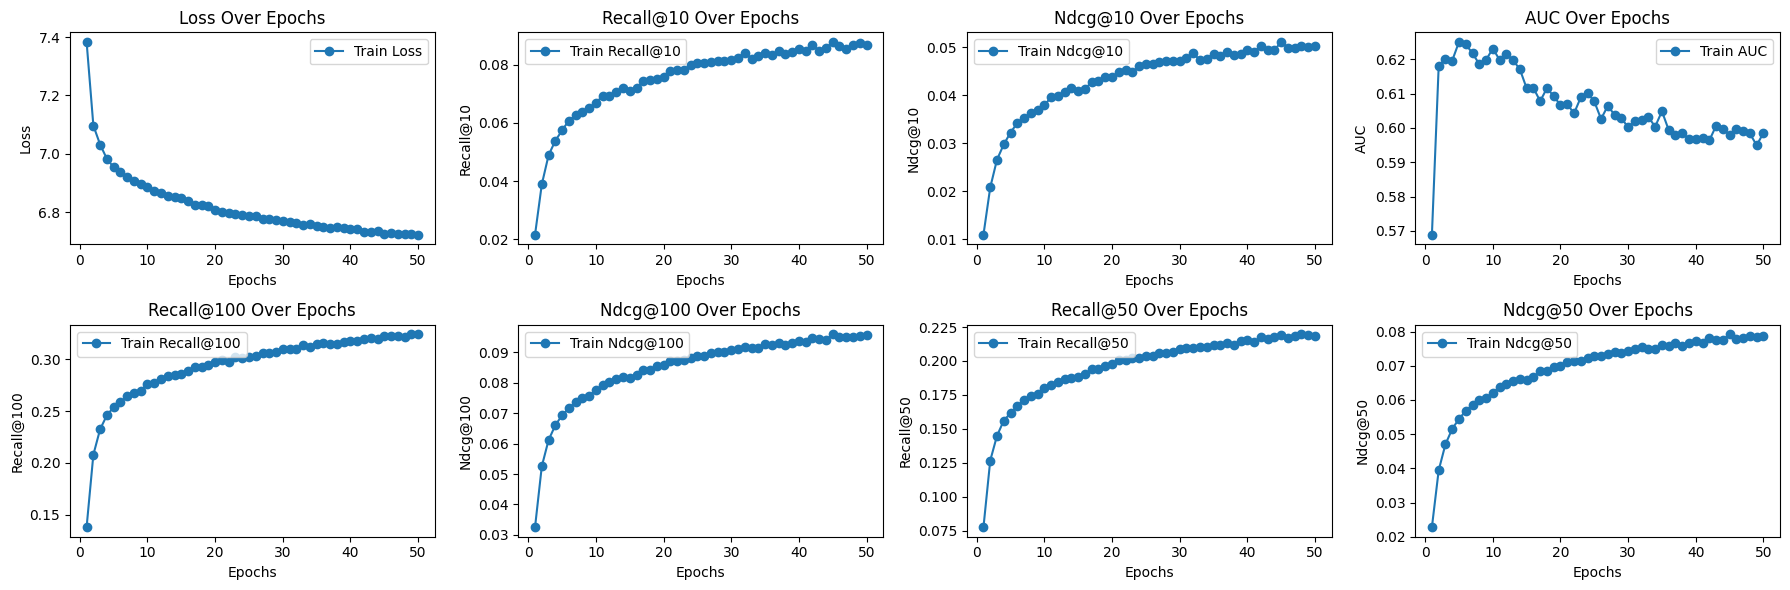

In [61]:
_history = merge_model_history(*history)
# AUC_TERM = [k for k in _history if k.startswith('auc')][0]
METRIC_AT = {'@'.join([k.split('_')[0].title(), k.split('_')[-1]]):k for k in _history if k.startswith('recall') or k.startswith('ndcg')}
val_history = { k[4:]:v for k,v in _history.items() if k.startswith('val')}
plot_metrics(_history, None, default_plot_metrics | {'AUC': 'auc', **METRIC_AT,})
# {'AUC': AUC_TERM, 'Recall@100': 'recall_at_100','NDCG@10': 'ndcg_at_10',}

### model_v4

In [32]:
VERSION = 'v4'

_tower_dim = {
    'user':[128, 128],
    'item':[512, 128],
}

_learning_rate = 0.01 # @param
_batch_size = 1024 * 2 # @param
_epochs = 50 # @param
_validation_batch_size = 2048 # @param
_sample_neg = _batch_size * 2 # @param
_validation_freq = 5 # @param
_loss = 'categorical_crossentropy' # @param
# _loss = 'bpr-max' # @param

_logq_sampling_correction = False # @param

embedding_dims = {
    'item': {
        'movie_id': 64,
        'genres': 8*2,
        'cast': 128
    },
    'user': {
        'user_id': 64,
        'gender': 8,
        'occupation': 8*2
    }
}

In [33]:
if VERSION in models:
    raise RuntimeError('Reusing model version: ', VERSION)

In [34]:
from merlin.models.tf.outputs.sampling.in_batch import InBatchSamplerV2

sampler = [InBatchSamplerV2(_sample_neg)]

models[VERSION] = model = build_towers(
    train,
    tower_dim=_tower_dim,
    neg_sampler=sampler,
    embedding_dims=embedding_dims,
    logq_sampling_correction=_logq_sampling_correction,
    item_categorical=item_embeddings_block  # needed to initiate the text embeddings
)

train_evaluation_clbks[VERSION] = EvaluationCallback(period=5, topk=100, data=train, type_='Train', schema=train.schema)
valid_evaluation_clbks[VERSION] = EvaluationCallback(period=5, topk=100, data=valid, type_='Validation', schema=train.schema)
historys[VERSION] = []

TOP_K = [100, 50, 10]
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
    run_eagerly=False,
    metrics=topk_metrics_aggregator(TOP_K),
    loss=_loss,
)

#### model

In [35]:
history = historys[VERSION]
model = models[VERSION]
train_evaluation_clbk = train_evaluation_clbks[VERSION]
valid_evaluation_clbk = valid_evaluation_clbks[VERSION]

In [36]:
# %pdb on
history.append(
    model.fit(train, validation_data=valid, batch_size=_batch_size, epochs=_epochs,
                 validation_batch_size=_validation_batch_size, validation_freq=_validation_freq,
                 callbacks=[train_evaluation_clbk,
                            valid_evaluation_clbk],
                  verbose=1)
)

KeyboardInterrupt: ignored

#### analysis

In [68]:
history = historys[VERSION]
model = models[VERSION]
train_evaluation_clbk = train_evaluation_clbks[VERSION]
valid_evaluation_clbk = valid_evaluation_clbks[VERSION]

Plot for model v4


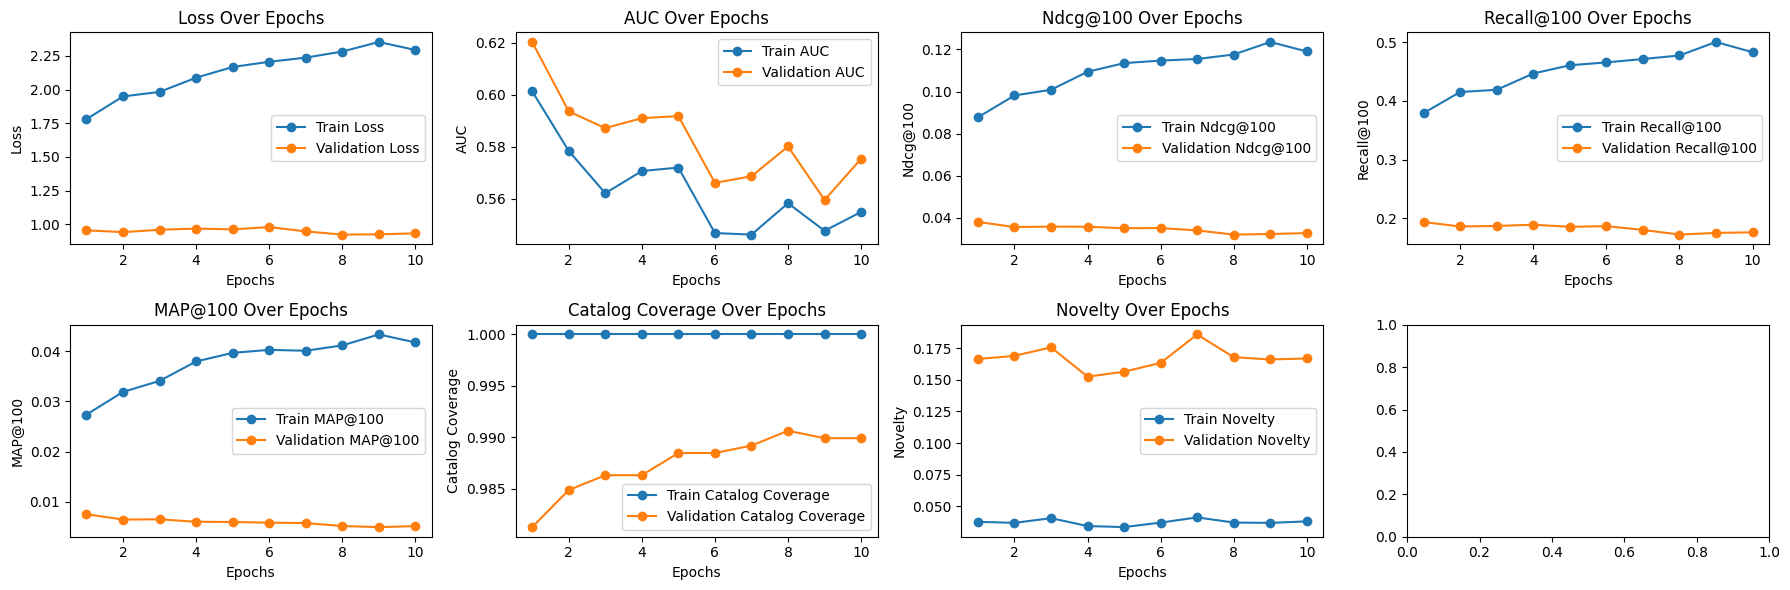

In [69]:
_history = train_evaluation_clbk.get_records()
_history_val = valid_evaluation_clbk.get_records()
AUC_TERM = [k for k in _history if k.startswith('auc')][0]
_metrics  = {
    'Loss': 'loss',
    'AUC': AUC_TERM,
    'Ndcg@100': 'ndcg_at_100',
    'Recall@100': 'recall_at_100',
    'MAP@100':'map_at_100',
    'Catalog Coverage': 'coverage',
    'Novelty':'novelty'
}
print('Plot for model', VERSION)
plot_metrics(_history, _history_val, _metrics)


Plot for model v10


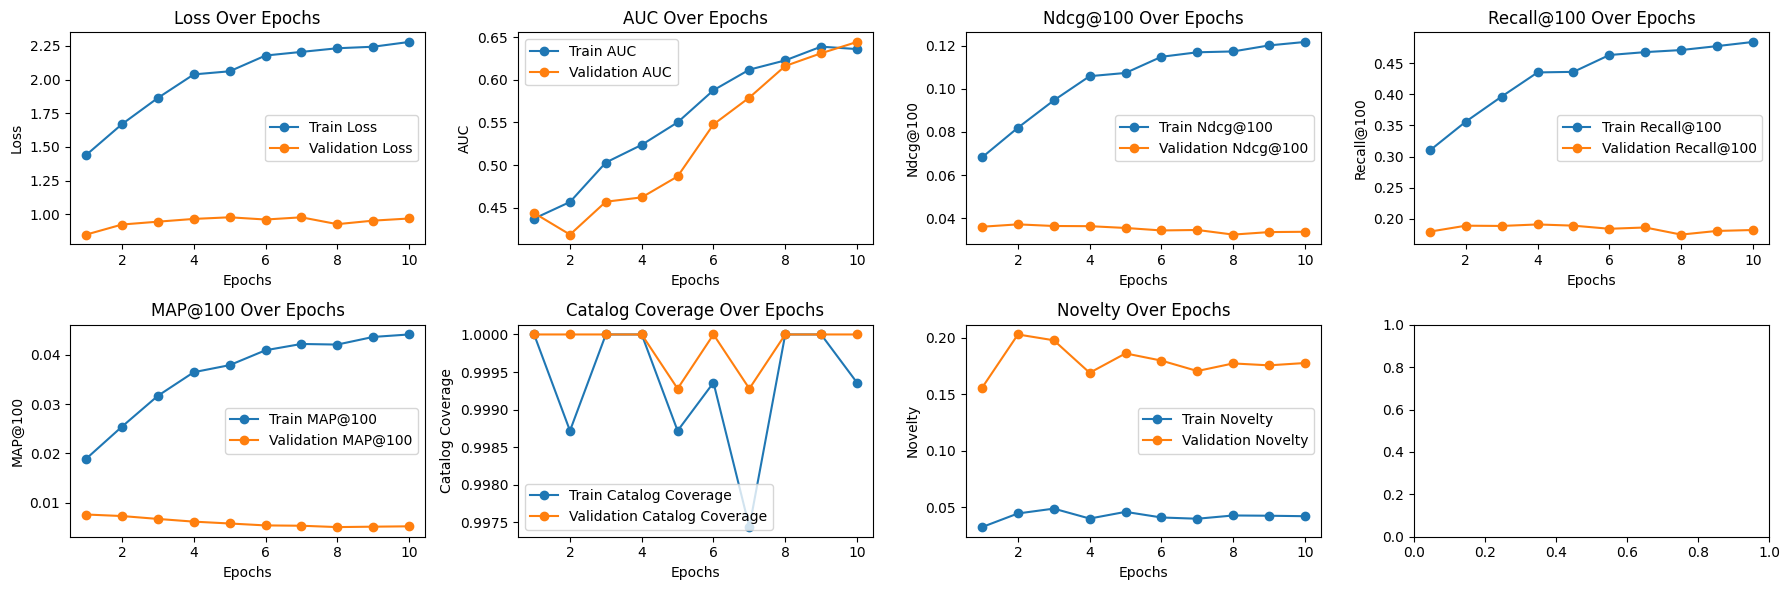

In [ ]:
_history = train_evaluation_clbk.get_records()
_history_val = valid_evaluation_clbk.get_records()
AUC_TERM = [k for k in _history if k.startswith('auc')][0]
_metrics  = {
    'Loss': 'loss',
    'AUC': AUC_TERM,
    'Ndcg@100': 'ndcg_at_100',
    'Recall@100': 'recall_at_100',
    'MAP@100':'map_at_100',
    'Catalog Coverage': 'coverage',
    'Novelty':'novelty'
}
print('Plot for model', VERSION)
plot_metrics(_history, _history_val, _metrics)


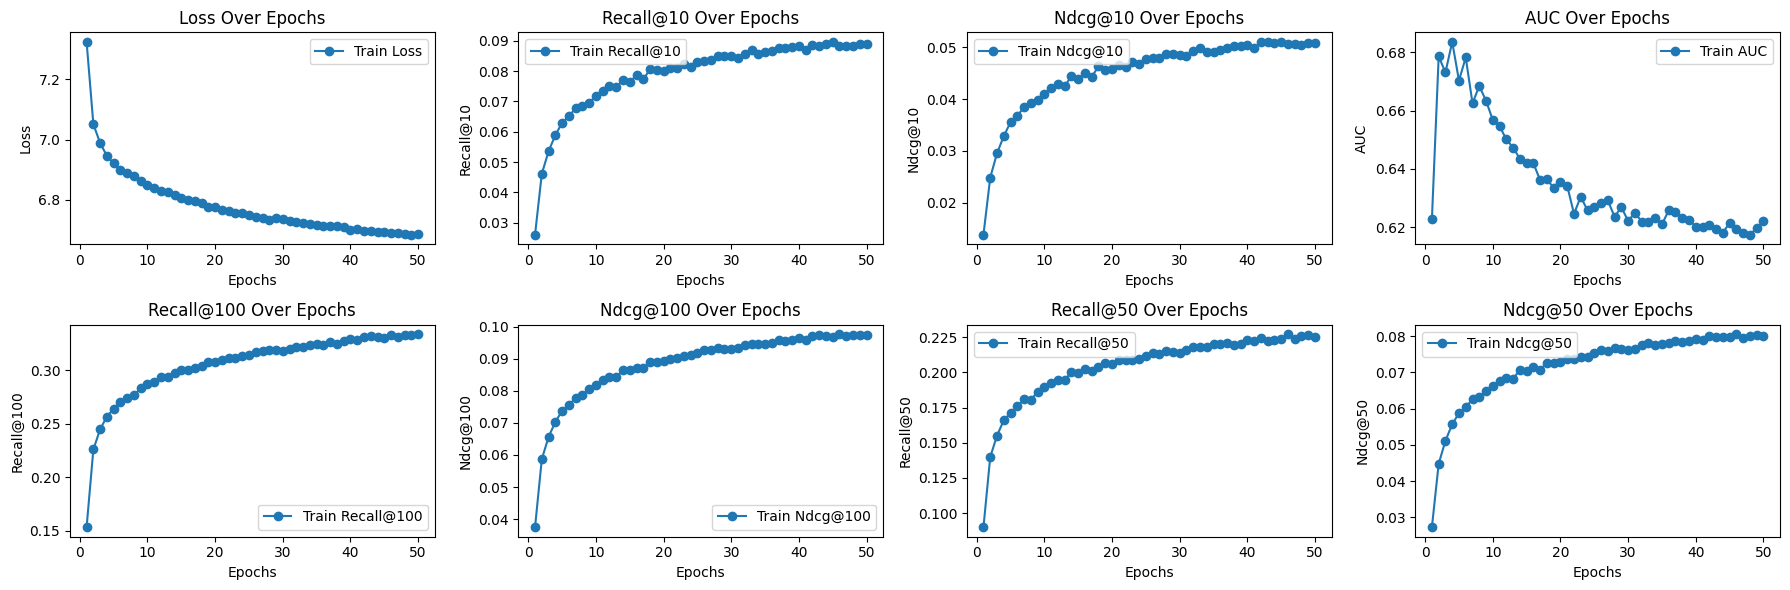

In [70]:
_history = merge_model_history(*history)
# AUC_TERM = [k for k in _history if k.startswith('auc')][0]
METRIC_AT = {'@'.join([k.split('_')[0].title(), k.split('_')[-1]]):k for k in _history if k.startswith('recall') or k.startswith('ndcg')}
val_history = { k[4:]:v for k,v in _history.items() if k.startswith('val')}
plot_metrics(_history, None, default_plot_metrics | {'AUC': 'auc', **METRIC_AT,})
# {'AUC': AUC_TERM, 'Recall@100': 'recall_at_100','NDCG@10': 'ndcg_at_10',}

### model_v5

In [28]:
VERSION = 'v5'

_tower_dim = {
    'user':[128, 128],
    'item':[512, 128],
}

_learning_rate = 0.01 # @param
_batch_size = 1024 * 2 # @param
_epochs = 50 # @param
_validation_batch_size = 2048 # @param
_sample_neg = _batch_size * 2 # @param
_validation_freq = 5 # @param
_loss = 'categorical_crossentropy' # @param
# _loss = 'bpr-max' # @param

_logq_sampling_correction = False # @param

embedding_dims = {
    'item': {
        'movie_id': 64,
        'genres': 8*2,
        'cast': 64
    },
    'user': {
        'user_id': 64,
        'gender': 8,
        'occupation': 8*2
    }
}

In [29]:
if VERSION in models:
    raise RuntimeError('Reusing model version: ', VERSION)

In [30]:
from merlin.models.tf.outputs.sampling.in_batch import InBatchSamplerV2

sampler = [InBatchSamplerV2(_sample_neg)]

models[VERSION] = model = build_towers(
    train,
    tower_dim=_tower_dim,
    neg_sampler=sampler,
    embedding_dims=embedding_dims,
    logq_sampling_correction=_logq_sampling_correction,
    item_categorical=item_embeddings_block  # needed to initiate the text embeddings
)

train_evaluation_clbks[VERSION] = EvaluationCallback(period=5, topk=100, data=train, type_='Train', schema=train.schema)
valid_evaluation_clbks[VERSION] = EvaluationCallback(period=5, topk=100, data=valid, type_='Validation', schema=train.schema)
historys[VERSION] = []

TOP_K = [100, 50, 10]
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
    run_eagerly=False,
    metrics=topk_metrics_aggregator(TOP_K),
    loss=_loss,
)

#### model

In [31]:
history = historys[VERSION]
model = models[VERSION]
train_evaluation_clbk = train_evaluation_clbks[VERSION]
valid_evaluation_clbk = valid_evaluation_clbks[VERSION]

In [ ]:
# %pdb on
history.append(
    model.fit(train, validation_data=valid, batch_size=_batch_size, epochs=_epochs,
                 validation_batch_size=_validation_batch_size, validation_freq=_validation_freq,
                 callbacks=[train_evaluation_clbk,
                            valid_evaluation_clbk],
                  verbose=1)
)

Epoch 1/50
35/35 [==============================] - 39s 565ms/step - loss: 7.4729 - auc: 0.5976 - recall_at_100: 0.0753 - mrr_at_100: 0.0052 - ndcg_at_100: 0.0169 - map_at_100: 0.0052 - precision_at_100: 7.5310e-04 - recall_at_50: 0.0390 - mrr_at_50: 0.0047 - ndcg_at_50: 0.0111 - map_at_50: 0.0047 - precision_at_50: 7.8098e-04 - recall_at_10: 0.0094 - mrr_at_10: 0.0035 - ndcg_at_10: 0.0049 - map_at_10: 0.0035 - precision_at_10: 9.3897e-04 - regularization_loss: 0.0000e+00 - loss_batch: 7.4054
Epoch 2/50
35/35 [==============================] - 14s 350ms/step - loss: 7.2310 - auc: 0.6584 - recall_at_100: 0.1593 - mrr_at_100: 0.0118 - ndcg_at_100: 0.0368 - map_at_100: 0.0118 - precision_at_100: 0.0016 - recall_at_50: 0.0893 - mrr_at_50: 0.0108 - ndcg_at_50: 0.0255 - map_at_50: 0.0108 - precision_at_50: 0.0018 - recall_at_10: 0.0229 - mrr_at_10: 0.0081 - ndcg_at_10: 0.0115 - map_at_10: 0.0081 - precision_at_10: 0.0023 - regularization_loss: 0.0000e+00 - loss_batch: 7.1655
Epoch 3/50
35/35

69/69 [==============================] - 8s 19ms/step - loss: 1.4797 - auc: 0.5308 - recall_at_100: 0.3206 - mrr_at_100: 0.0220 - ndcg_at_100: 0.0731 - map_at_100: 0.0220 - precision_at_100: 0.0032 - recall_at_10: 0.0463 - mrr_at_10: 0.0143 - ndcg_at_10: 0.0216 - map_at_10: 0.0143 - precision_at_10: 0.0046 - regularization_loss: 0.0000e+00 - loss_batch: 1.4862
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.4796708822250366, 'auc': 0.5307518243789673, 'recall_at_100': 0.32218456268310547, 'mrr_at_100': 0.02240043133497238, 'ndcg_at_100': 0.07367753982543945, 'map_at_100': 0.02240043133497238, 'precision_at_100': 0.003221845021471381, 'recall_at_10': 0.04686476290225983, 'mrr_at_10': 0.014668680727481842, 'ndcg_at_10': 0.02204325795173645, 'map_at_10': 0.014668680727481842, 'precision_at_10': 0.004686474800109863, 'regularization_loss': 0.0, 'loss_batch': 1.7942026853561401, 'coverage': 0.9910313901345291, 'novelty': 0.01670179415879988}
Candidate set rows: 1387


15/15 [==============================] - 4s 23ms/step - loss: 0.9701 - auc: 0.5283 - recall_at_100: 0.2011 - mrr_at_100: 0.0096 - ndcg_at_100: 0.0413 - map_at_100: 0.0096 - precision_at_100: 0.0020 - recall_at_10: 0.0174 - mrr_at_10: 0.0050 - ndcg_at_10: 0.0078 - map_at_10: 0.0050 - precision_at_10: 0.0017 - regularization_loss: 0.0000e+00 - loss_batch: 1.0192
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9700967669487, 'auc': 0.5283260941505432, 'recall_at_100': 0.2062324434518814, 'mrr_at_100': 0.01010348554700613, 'ndcg_at_100': 0.04270203784108162, 'map_at_100': 0.01010348554700613, 'precision_at_100': 0.002062324434518814, 'recall_at_10': 0.018590344116091728, 'mrr_at_10': 0.005297224037349224, 'ndcg_at_10': 0.00833151489496231, 'map_at_10': 0.005297224037349224, 'precision_at_10': 0.001859034295193851, 'regularization_loss': 0.0, 'loss_batch': 1.533103346824646, 'coverage': 0.9913482335976929, 'novelty': 0.09944110513550564}
35/35 [========================

69/69 [==============================] - 8s 28ms/step - loss: 1.5547 - auc: 0.5702 - recall_at_100: 0.3375 - mrr_at_100: 0.0240 - ndcg_at_100: 0.0777 - map_at_100: 0.0240 - precision_at_100: 0.0034 - recall_at_10: 0.0515 - mrr_at_10: 0.0160 - ndcg_at_10: 0.0242 - map_at_10: 0.0160 - precision_at_10: 0.0051 - regularization_loss: 0.0000e+00 - loss_batch: 1.5669
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.5546505451202393, 'auc': 0.5702477693557739, 'recall_at_100': 0.3359448313713074, 'mrr_at_100': 0.023740388453006744, 'ndcg_at_100': 0.07718534022569656, 'map_at_100': 0.023740388453006744, 'precision_at_100': 0.003359448630362749, 'recall_at_10': 0.05055411532521248, 'mrr_at_10': 0.0157616026699543, 'ndcg_at_10': 0.02374383807182312, 'map_at_10': 0.0157616026699543, 'precision_at_10': 0.005055410787463188, 'regularization_loss': 0.0, 'loss_batch': 2.149949550628662, 'coverage': 1.0, 'novelty': 0.03298817603022459}
Candidate set rows: 1387


15/15 [==============================] - 3s 23ms/step - loss: 0.9231 - auc: 0.5585 - recall_at_100: 0.1858 - mrr_at_100: 0.0080 - ndcg_at_100: 0.0372 - map_at_100: 0.0080 - precision_at_100: 0.0019 - recall_at_10: 0.0139 - mrr_at_10: 0.0038 - ndcg_at_10: 0.0061 - map_at_10: 0.0038 - precision_at_10: 0.0014 - regularization_loss: 0.0000e+00 - loss_batch: 0.9827
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9231263995170593, 'auc': 0.5585082173347473, 'recall_at_100': 0.19305871427059174, 'mrr_at_100': 0.008507427759468555, 'ndcg_at_100': 0.03894232586026192, 'map_at_100': 0.008507427759468555, 'precision_at_100': 0.001930587226524949, 'recall_at_10': 0.014778654091060162, 'mrr_at_10': 0.004078565631061792, 'ndcg_at_10': 0.006514254026114941, 'map_at_10': 0.004078565631061792, 'precision_at_10': 0.0014778653858229518, 'regularization_loss': 0.0, 'loss_batch': 1.60548996925354, 'coverage': 0.9985580389329488, 'novelty': 0.14483182306865305}
35/35 [=================

69/69 [==============================] - 5s 20ms/step - loss: 1.6992 - auc: 0.5481 - recall_at_100: 0.3660 - mrr_at_100: 0.0272 - ndcg_at_100: 0.0856 - map_at_100: 0.0272 - precision_at_100: 0.0037 - recall_at_10: 0.0596 - mrr_at_10: 0.0184 - ndcg_at_10: 0.0278 - map_at_10: 0.0184 - precision_at_10: 0.0060 - regularization_loss: 0.0000e+00 - loss_batch: 1.7103
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.6991863250732422, 'auc': 0.5480570793151855, 'recall_at_100': 0.3656163513660431, 'mrr_at_100': 0.027774278074502945, 'ndcg_at_100': 0.08601782470941544, 'map_at_100': 0.027774278074502945, 'precision_at_100': 0.0036561633460223675, 'recall_at_10': 0.05988433212041855, 'mrr_at_10': 0.01902640424668789, 'ndcg_at_10': 0.028394293040037155, 'map_at_10': 0.01902640424668789, 'precision_at_10': 0.0059884339570999146, 'regularization_loss': 0.0, 'loss_batch': 2.2405996322631836, 'coverage': 0.9993593850096092, 'novelty': 0.032844554351990525}
Candidate set rows: 1387


15/15 [==============================] - 5s 24ms/step - loss: 0.9390 - auc: 0.5405 - recall_at_100: 0.1883 - mrr_at_100: 0.0074 - ndcg_at_100: 0.0371 - map_at_100: 0.0074 - precision_at_100: 0.0019 - recall_at_10: 0.0129 - mrr_at_10: 0.0031 - ndcg_at_10: 0.0053 - map_at_10: 0.0031 - precision_at_10: 0.0013 - regularization_loss: 0.0000e+00 - loss_batch: 0.9858
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.9389702081680298, 'auc': 0.5405386090278625, 'recall_at_100': 0.19245687127113342, 'mrr_at_100': 0.0076851798221468925, 'ndcg_at_100': 0.038028646260499954, 'map_at_100': 0.0076851798221468925, 'precision_at_100': 0.0019245685543864965, 'recall_at_10': 0.013307476416230202, 'mrr_at_10': 0.0033060379792004824, 'ndcg_at_10': 0.005568246822804213, 'map_at_10': 0.0033060379792004824, 'precision_at_10': 0.0013307476183399558, 'regularization_loss': 0.0, 'loss_batch': 1.475577712059021, 'coverage': 0.9956741167988464, 'novelty': 0.15612582781456952}
35/35 [==========

69/69 [==============================] - 5s 20ms/step - loss: 1.7591 - auc: 0.5663 - recall_at_100: 0.3762 - mrr_at_100: 0.0291 - ndcg_at_100: 0.0891 - map_at_100: 0.0291 - precision_at_100: 0.0038 - recall_at_10: 0.0631 - mrr_at_10: 0.0201 - ndcg_at_10: 0.0300 - map_at_10: 0.0201 - precision_at_10: 0.0063 - regularization_loss: 0.0000e+00 - loss_batch: 1.7724
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.7590700387954712, 'auc': 0.5662535429000854, 'recall_at_100': 0.3768980801105499, 'mrr_at_100': 0.02937544323503971, 'ndcg_at_100': 0.08939678221940994, 'map_at_100': 0.02937544323503971, 'precision_at_100': 0.00376898143440485, 'recall_at_10': 0.06279023736715317, 'mrr_at_10': 0.020322343334555626, 'ndcg_at_10': 0.03006879612803459, 'map_at_10': 0.020322343334555626, 'precision_at_10': 0.0062790242955088615, 'regularization_loss': 0.0, 'loss_batch': 2.4073140621185303, 'coverage': 1.0, 'novelty': 0.04089864249468708}
Candidate set rows: 1387


15/15 [==============================] - 5s 32ms/step - loss: 0.9325 - auc: 0.5629 - recall_at_100: 0.1844 - mrr_at_100: 0.0069 - ndcg_at_100: 0.0359 - map_at_100: 0.0069 - precision_at_100: 0.0018 - recall_at_10: 0.0109 - mrr_at_10: 0.0026 - ndcg_at_10: 0.0045 - map_at_10: 0.0026 - precision_at_10: 0.0011 - regularization_loss: 0.0000e+00 - loss_batch: 0.9833
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.93254554271698, 'auc': 0.562873363494873, 'recall_at_100': 0.18817707896232605, 'mrr_at_100': 0.0071137044578790665, 'ndcg_at_100': 0.03676147386431694, 'map_at_100': 0.0071137044578790665, 'precision_at_100': 0.0018817705567926168, 'recall_at_10': 0.011769426055252552, 'mrr_at_10': 0.002821138361468911, 'ndcg_at_10': 0.00484740175306797, 'map_at_10': 0.002821138361468911, 'precision_at_10': 0.0011769424891099334, 'regularization_loss': 0.0, 'loss_batch': 1.5139265060424805, 'coverage': 0.9949531362653208, 'novelty': 0.17027807872878295}
35/35 [================

69/69 [==============================] - 7s 31ms/step - loss: 1.9508 - auc: 0.5515 - recall_at_100: 0.4172 - mrr_at_100: 0.0325 - ndcg_at_100: 0.0992 - map_at_100: 0.0325 - precision_at_100: 0.0042 - recall_at_10: 0.0717 - mrr_at_10: 0.0225 - ndcg_at_10: 0.0338 - map_at_10: 0.0225 - precision_at_10: 0.0072 - regularization_loss: 0.0000e+00 - loss_batch: 1.9621
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.9508363008499146, 'auc': 0.5515309572219849, 'recall_at_100': 0.41967466473579407, 'mrr_at_100': 0.033219192177057266, 'ndcg_at_100': 0.10020792484283447, 'map_at_100': 0.033219192177057266, 'precision_at_100': 0.004196746740490198, 'recall_at_10': 0.07182131707668304, 'mrr_at_10': 0.023025749251246452, 'ndcg_at_10': 0.03422502428293228, 'map_at_10': 0.023025749251246452, 'precision_at_10': 0.0071821315214037895, 'regularization_loss': 0.0, 'loss_batch': 2.4991462230682373, 'coverage': 1.0, 'novelty': 0.0344651145791455}
Candidate set rows: 1387


15/15 [==============================] - 3s 23ms/step - loss: 0.9450 - auc: 0.5598 - recall_at_100: 0.1816 - mrr_at_100: 0.0070 - ndcg_at_100: 0.0355 - map_at_100: 0.0070 - precision_at_100: 0.0018 - recall_at_10: 0.0111 - mrr_at_10: 0.0029 - ndcg_at_10: 0.0047 - map_at_10: 0.0029 - precision_at_10: 0.0011 - regularization_loss: 0.0000e+00 - loss_batch: 0.9853
Candidate set rows: 943
Validation dataset topk evaluation {'loss': 0.945000410079956, 'auc': 0.5597655773162842, 'recall_at_100': 0.19091881811618805, 'mrr_at_100': 0.007316699717193842, 'ndcg_at_100': 0.037431735545396805, 'map_at_100': 0.007316699717193842, 'precision_at_100': 0.0019091881113126874, 'recall_at_10': 0.012304400093853474, 'mrr_at_10': 0.002954934723675251, 'ndcg_at_10': 0.005066430661827326, 'map_at_10': 0.002954934723675251, 'precision_at_10': 0.0012304401025176048, 'regularization_loss': 0.0, 'loss_batch': 1.4068925380706787, 'coverage': 0.9942321557317952, 'novelty': 0.15910241268770034}
35/35 [==============

69/69 [==============================] - 5s 20ms/step - loss: 1.9554 - auc: 0.5523 - recall_at_100: 0.4185 - mrr_at_100: 0.0338 - ndcg_at_100: 0.1005 - map_at_100: 0.0338 - precision_at_100: 0.0042 - recall_at_10: 0.0730 - mrr_at_10: 0.0237 - ndcg_at_10: 0.0350 - map_at_10: 0.0237 - precision_at_10: 0.0073 - regularization_loss: 0.0000e+00 - loss_batch: 1.9695
Candidate set rows: 943
Train dataset topk evaluation {'loss': 1.955385684967041, 'auc': 0.552325427532196, 'recall_at_100': 0.4175094664096832, 'mrr_at_100': 0.0344824381172657, 'ndcg_at_100': 0.1009739562869072, 'map_at_100': 0.0344824381172657, 'precision_at_100': 0.004175093956291676, 'recall_at_10': 0.0728469267487526, 'mrr_at_10': 0.0243171826004982, 'ndcg_at_10': 0.03547760471701622, 'map_at_10': 0.0243171826004982, 'precision_at_10': 0.0072846924886107445, 'regularization_loss': 0.0, 'loss_batch': 2.638927698135376, 'coverage': 0.9993593850096092, 'novelty': 0.03697749196141479}
Candidate set rows: 1387


#### analysis

In [ ]:
history = historys[VERSION]
model = models[VERSION]
train_evaluation_clbk = train_evaluation_clbks[VERSION]
valid_evaluation_clbk = valid_evaluation_clbks[VERSION]

Plot for model v4


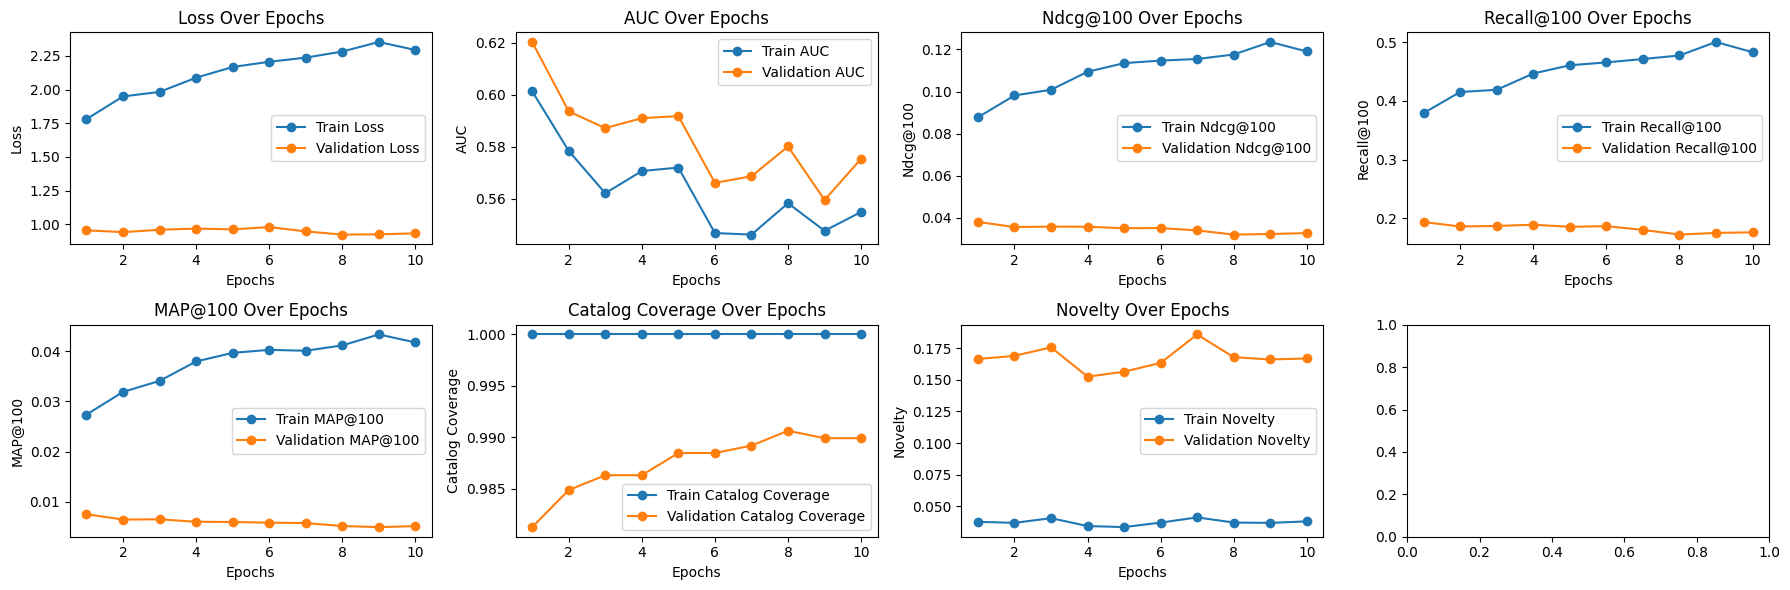

In [ ]:
_history = train_evaluation_clbk.get_records()
_history_val = valid_evaluation_clbk.get_records()
AUC_TERM = [k for k in _history if k.startswith('auc')][0]
_metrics  = {
    'Loss': 'loss',
    'AUC': AUC_TERM,
    'Ndcg@100': 'ndcg_at_100',
    'Recall@100': 'recall_at_100',
    'MAP@100':'map_at_100',
    'Catalog Coverage': 'coverage',
    'Novelty':'novelty'
}
print('Plot for model', VERSION)
plot_metrics(_history, _history_val, _metrics)


Plot for model v10


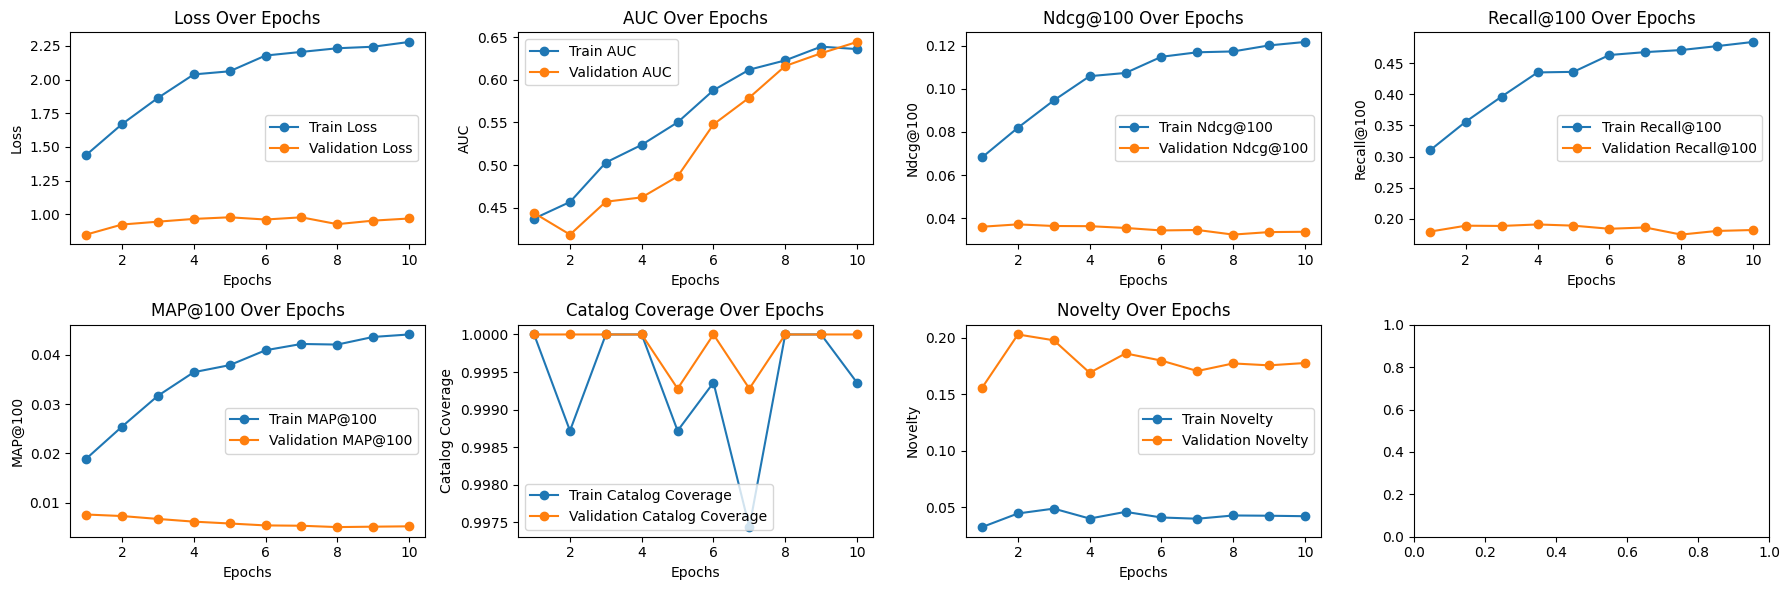

In [ ]:
_history = train_evaluation_clbk.get_records()
_history_val = valid_evaluation_clbk.get_records()
AUC_TERM = [k for k in _history if k.startswith('auc')][0]
_metrics  = {
    'Loss': 'loss',
    'AUC': AUC_TERM,
    'Ndcg@100': 'ndcg_at_100',
    'Recall@100': 'recall_at_100',
    'MAP@100':'map_at_100',
    'Catalog Coverage': 'coverage',
    'Novelty':'novelty'
}
print('Plot for model', VERSION)
plot_metrics(_history, _history_val, _metrics)


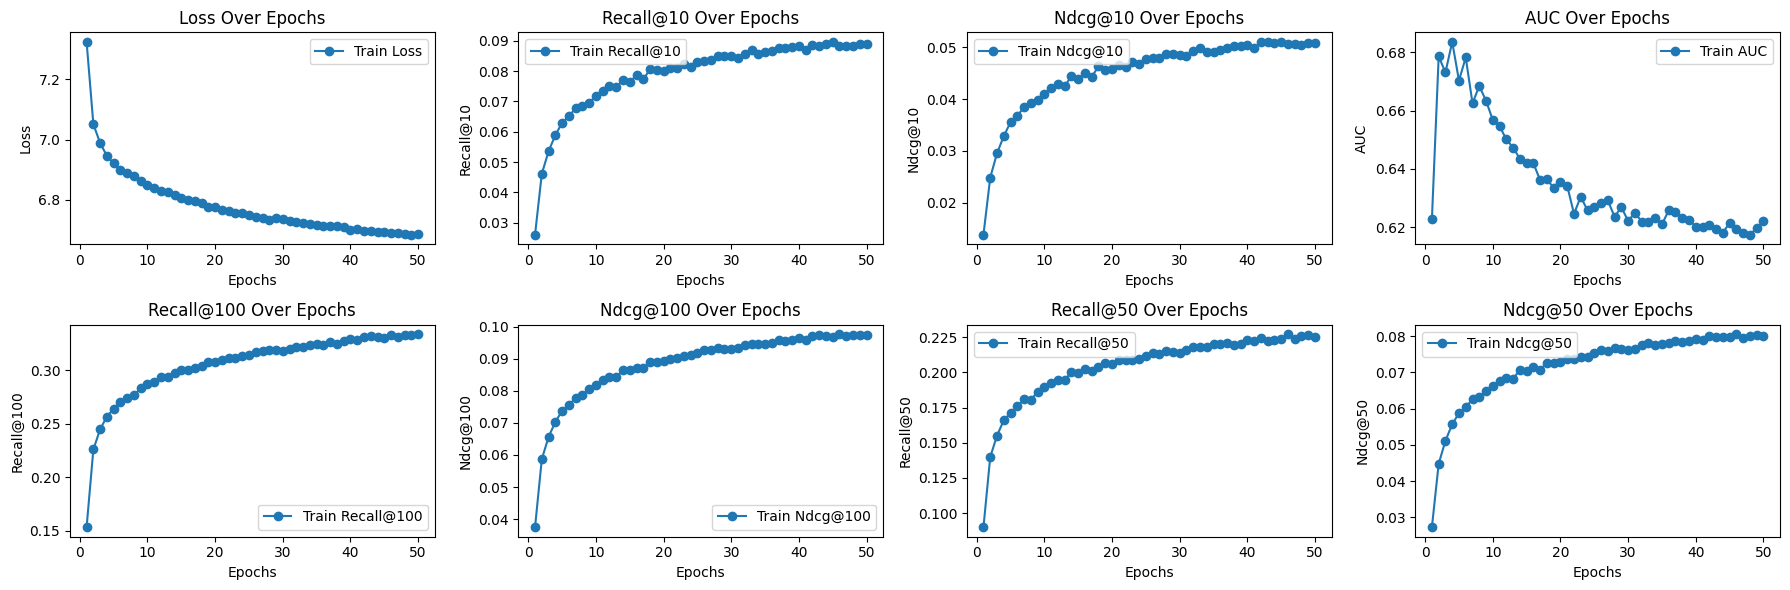

In [ ]:
_history = merge_model_history(*history)
# AUC_TERM = [k for k in _history if k.startswith('auc')][0]
METRIC_AT = {'@'.join([k.split('_')[0].title(), k.split('_')[-1]]):k for k in _history if k.startswith('recall') or k.startswith('ndcg')}
val_history = { k[4:]:v for k,v in _history.items() if k.startswith('val')}
plot_metrics(_history, None, default_plot_metrics | {'AUC': 'auc', **METRIC_AT,})
# {'AUC': AUC_TERM, 'Recall@100': 'recall_at_100','NDCG@10': 'ndcg_at_10',}